In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from itertools import chain
from tqdm import tqdm
from skspatial.objects import Points, Line

import warnings
import pandas as pd

# Suppress pandas’ SettingWithCopyWarning
pd.options.mode.chained_assignment = None  

# Suppress all FutureWarning (including your Series positional‐indexing warning)
warnings.filterwarnings("ignore", category=FutureWarning)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15

In [2]:
#### fit_parameters
dist_z = 8.5 # [mm] distance between planes
Lgap = 4.85 # GAP STAVE mm + addition distance for space compliance (mechanincal)
Sgap = 0.15 # GAP CHIP mm

max_point_forfit = 20
n_minpoints_HT = 2
dist_max = 3 # max distance for track association
theta_point_HT = 1000 #5000 # number of points sample with the HT
theta_binning_HT = 500 #500 # number of points sample with the HT
rho_binning_HT = 500 #500 # number of points sample with the HT

#### dumping_tracks
max_res_dump = 1000 # [mm] max error on a track to be dumped


In [3]:
def display_single_fit(ev,vec_reco,cent_reco,outname,planelabel):

    eps = 0.0000001

    vec_reco = np.array(vec_reco)
    vec_reco = np.where(vec_reco==0,eps,vec_reco)

    color = ['b','r','g','k','y','m','c','b','r','g','k','y','m','c','b','r','g','k','y','m','c','b','r','g','k','y','m','c','b','r','g','k','y','m','c','b','r','g','k','y','m','c']

    fig = plt.figure(figsize = (20,8))
    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, :2])
    #plt.subplot(1,3,1)
    plt.title('x-z view',fontsize = 15)
    for i,i_trk in enumerate(np.unique(ev.trk_nr.values)):
        ev_trk = ev[ev.trk_nr == i_trk]
        if len(ev_trk)>=2 and i_trk != -1:
            ax1.scatter(ev_trk.x_pos.values,ev_trk.z_pos.values, c = color[int(i_trk)], label = 'track '+str(int(ev_trk.trk_nr.values[0]))+", HT plane "+planelabel, alpha = 0.5, s = 100)
            ax1.plot(np.linspace(0,150),(cent_reco[i][2]-cent_reco[i][0]*vec_reco[i][2]/vec_reco[i][0]) + vec_reco[i][2]/vec_reco[i][0] * np.linspace(0,150), c = color[int(i_trk)], label = 'fit track '+str(int(ev_trk.trk_nr.values[0])))
        else:
            ax1.scatter(ev_trk.x_pos.values,ev_trk.z_pos.values, c = color[-1], label = 'noise', alpha = 0.5, s = 100)
    ax1.legend()
    ax1.plot([0.,150.],[0.,0.], color = 'blue')
    ax1.plot([0.,150.],[-1*dist_z,-1*dist_z], color = 'blue')
    ax1.plot([0.,150.],[-2*dist_z,-2*dist_z], color = 'blue')
    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('z [mm]')
    ax1.grid(alpha = 0.5)
    ax1.set_xlim(-10,160)
    ax1.set_ylim(-25.5,8.5)

    #plt.subplot(1,3,2)
    ax2 = fig.add_subplot(gs[1, :2])
    plt.title('y-z view',fontsize = 15)
    for i,i_trk in enumerate(np.unique(ev.trk_nr.values)):
        ev_trk = ev[ev.trk_nr == i_trk]
        if len(ev_trk)>=2 and i_trk != -1:
            ax2.scatter(ev_trk.y_pos.values,ev_trk.z_pos.values, c = color[int(i_trk)], label = 'track '+str(int(ev_trk.trk_nr.values[0]))+", HT plane "+planelabel, alpha = 0.5, s = 100)
            ax2.plot(np.linspace(0.,175.),(cent_reco[i][2]-cent_reco[i][1]*vec_reco[i][2]/vec_reco[i][1]) + vec_reco[i][2]/vec_reco[i][1] * np.linspace(0.,175.), c = color[int(i_trk)], label = 'fit track '+str(int(ev_trk.trk_nr.values[0])))
        else:
            ax2.scatter(ev_trk.y_pos.values,ev_trk.z_pos.values, c = color[-1], label = 'noise', alpha = 0.5, s = 100)
    ax2.legend()
    for tur in range(0,5):
        shift = tur*(30+Lgap+Sgap)
        ax2.plot([shift + 0.,shift + 30.],[0.,0.], color = 'blue')
        ax2.plot([shift + 0.,shift + 30.],[-1*dist_z,-1*dist_z], color = 'blue')
        ax2.plot([shift + 0.,shift + 30.],[-2*dist_z,-2*dist_z], color = 'blue')
    ax2.set_xlabel('y [mm]')
    ax2.set_ylabel('z [mm]')
    ax2.grid(alpha = 0.5)
    ax2.set_xlim(-10,180)
    ax2.set_ylim(-25.5,8.5)
    
    #plt.subplot(1,3,3)
    ax3 = fig.add_subplot(gs[:, 2])
    plt.title('x-y view',fontsize = 15)
    for i,i_trk in enumerate(np.unique(ev.trk_nr.values)):
        ev_trk = ev[ev.trk_nr == i_trk]
        if len(ev_trk)>=2 and i_trk != -1:
            ax3.scatter(ev_trk.x_pos.values,ev_trk.y_pos.values, c = color[int(i_trk)], label = 'track '+str(int(ev_trk.trk_nr.values[0]))+", HT plane "+planelabel, alpha = 0.5, s = 100)
            ax3.plot(np.linspace(0,150),(cent_reco[i][1]-cent_reco[i][0]*vec_reco[i][1]/vec_reco[i][0]) + vec_reco[i][1]/vec_reco[i][0] * np.linspace(0,150), c = color[int(i_trk)], label = 'fit track '+str(int(ev_trk.trk_nr.values[0])))
        else:
            ax3.scatter(ev_trk.x_pos.values,ev_trk.y_pos.values, c = color[-1], label = 'noise', alpha = 0.5, s = 100)
    ax3.legend()

    for tur in range(0,5):
        shift = tur*(30+Lgap+Sgap)
        ax3.plot([0.,150.],[shift + 0.,shift + 0.], color = 'blue')
        ax3.plot([0.,150.],[shift + 30.,shift + 30.], color = 'blue')
        ax3.plot([0.,0.],[shift + 0.,shift + 30.], color = 'blue')
        ax3.plot([150.,150.],[shift + 0.,shift + 30.], color = 'blue')
    
    ax3.set_xlabel('x [mm]')
    ax3.set_ylabel('y [mm]')
    ax3.grid(alpha = 0.5)
    ax3.set_xlim(-10,160)
    ax3.set_ylim(-15,180)
    
    plt.tight_layout()
    plt.savefig(outname)

In [4]:
def res_calculation_Xsigned(ev,vec_reco,cent_reco):
    dist = []
    eps = 0.0000001

    vec_reco = np.array(vec_reco)
    vec_reco = np.where(vec_reco==0,eps,vec_reco)

    for i in range(0,len(ev)):
        x_point = ev.x_pos.values[i]
        x_point_line = ev.z_pos.values[i]/(vec_reco[2]/vec_reco[0]) - (cent_reco[2]-cent_reco[0]*vec_reco[2]/vec_reco[0])/(vec_reco[2]/vec_reco[0])
        dist.append(x_point_line-x_point)
    return dist

def res_calculation_Ysigned(ev,vec_reco,cent_reco):
    dist = []
    eps = 0.0000001

    vec_reco = np.array(vec_reco)
    vec_reco = np.where(vec_reco==0,eps,vec_reco)

    for i in range(0,len(ev)):
        y_point = ev.y_pos.values[i]
        y_point_line = ev.z_pos.values[i]/(vec_reco[2]/vec_reco[1]) - (cent_reco[2]-cent_reco[1]*vec_reco[2]/vec_reco[1])/(vec_reco[2]/vec_reco[1])
        dist.append(y_point_line-y_point)
    return np.array(dist)

def res_calculation(ev,vec_reco,cent_reco):
    dist = []
    for i in range(0,len(ev)):
        point = np.array([ev.x_pos.values[i],ev.y_pos.values[i],ev.z_pos.values[i]])
        point_line = np.array(cent_reco)
        t_min = np.dot(point-point_line,vec_reco)/np.linalg.norm(vec_reco)**2
        dist.append(np.sqrt((cent_reco[0]+t_min*vec_reco[0]-point[0])**2+(cent_reco[1]+t_min*vec_reco[1]-point[1])**2+(cent_reco[2]+t_min*vec_reco[2]-point[2])**2))
    return dist

In [5]:
def distanceSegment3D(p,a,b):
    # normalized tangent vector
    d = np.divide(b - a, np.linalg.norm(b - a))
    # signed parallel distance components
    s = np.dot(a - p, d)
    t = np.dot(p - b, d)
    # clamped parallel distance
    h = np.maximum.reduce([s, t, 0])
    # perpendicular distance component
    c = np.cross(p - a, d)
    return np.hypot(h, np.linalg.norm(c))

def distancePointLine(x_point,y_point,q,m):
    return np.abs(y_point-(m*x_point+q))/(np.sqrt(1+m**2))

def point_Rtheta(x,y,theta):
    return np.cos(theta)*x+np.sin(theta)*y

def fitline(rho,theta):
    x_0 = rho*np.cos(theta)
    y_0 = rho*np.sin(theta)
    q = y_0+x_0/np.tan(theta)
    m = -1/np.tan(theta)
    return q,m

def calc_weight_TrkAss(ev):
    num = len(ev[ev.trk_nr != -1])
    den = len(ev)
    return den-num#10/(num/den)

def IterativeHoughTransform(df_events,i_ev,dim1,dim2):
    #print(dim1,dim2)
    i_track = 0
    df_ev = df_events[df_events.event==i_ev]
    while len(df_ev[df_ev["trk_nr"] == -1]) >= 3:
        #print(df_ev)
        theta_tot, rho_tot = [],[]

        for row in df_ev[df_ev["trk_nr"] == -1].iterrows():

            if (dim1 == "x_pos" and dim2 == "z_pos"):
                theta = np.concatenate((np.linspace(0.,np.pi/2-0.2,int(theta_point_HT/2)),np.linspace(np.pi/2+0.2,np.pi,int(theta_point_HT/2))))
            if (dim1 == "y_pos" and dim2 == "z_pos"):
                theta = np.concatenate((np.linspace(0.,np.pi/2-0.2,int(theta_point_HT/2)),np.linspace(np.pi/2+0.2,np.pi,int(theta_point_HT/2))))
            if (dim1 == "x_pos" and dim2 == "y_pos"):
                theta = np.linspace(0.,np.pi,theta_point_HT)

            rho = point_Rtheta(row[1][dim1],row[1][dim2],theta)
            theta_tot.append(theta)
            rho_tot.append(rho)

        theta_tot = list(chain.from_iterable(theta_tot))
        rho_tot = list(chain.from_iterable(rho_tot))
        hist,bin_x,bin_y = np.histogram2d(theta_tot,rho_tot,bins=[theta_binning_HT,rho_binning_HT], range=([0,np.pi],[-300,300]))
        
        x_ind, y_ind = np.unravel_index(np.argmax(hist), hist.shape)
        bin_x_vec = (bin_x[x_ind]+bin_x[x_ind+1])/2
        bin_y_vec = (bin_y[y_ind]+bin_y[y_ind+1])/2
        q, m = fitline(bin_y_vec,bin_x_vec)
        for row in df_ev[df_ev["trk_nr"] == -1].iterrows():
            x_point, y_point = row[1][dim1], row[1][dim2]
            d = distancePointLine(x_point, y_point, q, m)
            if d < dist_max :
                df_events['trk_nr'].loc[row[0]] = i_track
            #print(d)
        i_track += 1
        df_ev = df_events[df_events.event==i_ev]
        #print(df_ev)
    return df_events


def ChooseBestHough(df_h_xy,df_h_xz,df_h_yz):
    tot_ev = np.unique(np.concatenate((np.unique(df_h_xy.event.values),np.unique(df_h_xz.event.values),np.unique(df_h_yz.event.values)),axis=0))
    df_sel_tot = pd.DataFrame()
    plane_choosen = []
    for __,i_ev in tqdm(enumerate(tot_ev), total = len(tot_ev)):
        skip = False
        plane = ""
        #print("xy",df_h_xy)
        #print("xz",df_h_xz)
        #print("yz",df_h_yz)
        df_sel = pd.DataFrame()
        if len(df_h_xy[df_h_xy.event == i_ev])<=n_minpoints_HT:
            df_sel = df_h_xy[df_h_xy.event == i_ev]
            plane = "xy"
        else:
            fin_res = []
            fin_w = []
            if (False)&(len(df_h_xy[(df_h_xy.event == i_ev) & (df_h_xy.trk_nr != -1)])>0):
            
                ev = df_h_xy[(df_h_xy.event == i_ev) & (df_h_xy.trk_nr!=-1)]
                ev_vec_reco, ev_cent_reco, points_onplanes = [], [], []
                res_tot = 0
                for i_trk,j in enumerate(np.unique(ev.trk_nr.values)):
                    trk = ev[ev.trk_nr == j]
                    vec_reco,cent_reco,points_onplanes = ev_fitpoints(trk)
                    res_x = res_calculation_Xsigned(trk,vec_reco,cent_reco)
                    res_y = res_calculation_Ysigned(trk,vec_reco,cent_reco)
                    res_tot += np.sum(np.abs(np.concatenate([res_x,res_y],axis=0)))
                w = calc_weight_TrkAss(df_h_xy[(df_h_xy.event == i_ev)])
                fin_w.append(w)
                fin_res.append(res_tot+w)
                # already good track skip other projections
                if res_tot<1.:
                    skip = True
            else:
                fin_res.append(1000)

            if (len(df_h_xz[(df_h_xz.event == i_ev) & (df_h_xz.trk_nr != -1)])>0):

                ev = df_h_xz[(df_h_xz.event == i_ev) & (df_h_xz.trk_nr!=-1)]
                ev_vec_reco, ev_cent_reco, points_onplanes = [], [], []
                res_tot = 0
                for i_trk,j in enumerate(np.unique(ev.trk_nr.values)):
                    trk = ev[ev.trk_nr == j]
                    vec_reco,cent_reco,points_onplanes = ev_fitpoints(trk)
                    res_x = res_calculation_Xsigned(trk,vec_reco,cent_reco)
                    res_y = res_calculation_Ysigned(trk,vec_reco,cent_reco)
                    res_tot += np.sum(np.abs(np.concatenate([res_x,res_y],axis=0)))
                w = calc_weight_TrkAss(df_h_xz[(df_h_xz.event == i_ev)])
                fin_w.append(w)
                fin_res.append(res_tot+w)
                if res_tot<1.:
                    skip = True
            else:
                fin_res.append(1000)

            if (len(df_h_yz[(df_h_yz.event == i_ev) & (df_h_yz.trk_nr != -1)])>0):
                
                ev = df_h_yz[(df_h_yz.event == i_ev) & (df_h_yz.trk_nr!=-1)]
                ev_vec_reco, ev_cent_reco, points_onplanes = [], [], []
                res_tot = 0
                for i_trk,j in enumerate(np.unique(ev.trk_nr.values)):
                    trk = ev[ev.trk_nr == j]
                    vec_reco,cent_reco,points_onplanes = ev_fitpoints(trk)
                    res_x = res_calculation_Xsigned(trk,vec_reco,cent_reco)
                    res_y = res_calculation_Ysigned(trk,vec_reco,cent_reco)
                    res_tot += np.sum(np.abs(np.concatenate([res_x,res_y],axis=0)))
                w = calc_weight_TrkAss(df_h_yz[(df_h_yz.event == i_ev)])
                fin_w.append(w)
                fin_res.append(res_tot+w)
                if res_tot<1.:
                    skip = True
            else:
                fin_res.append(1000)

            if np.argmin(fin_res) == 0:
                df_sel = df_h_xy[df_h_xy.event == i_ev]
                plane = "xy"
            if np.argmin(fin_res) == 1:
                df_sel = df_h_xz[df_h_xz.event == i_ev]
                plane = "xz"
            if np.argmin(fin_res) == 2:
                df_sel = df_h_yz[df_h_yz.event == i_ev]
                plane = "yz"
        plane_choosen.append(plane)
        df_sel_tot = pd.concat([df_sel_tot,df_sel])
    return df_sel_tot, plane_choosen
    

def HoughTransform_xy(df_events_old):
    df_events = df_events_old.copy()
    df_events["trk_nr"] = -1*np.ones(len(df_events)) 

    for __,i_ev in tqdm(enumerate(np.unique(df_events.event)),total = len(np.unique(df_events.event))):

        df_ev = df_events[df_events.event==i_ev]
        if len(df_ev)<=n_minpoints_HT:
            for row in df_ev.iterrows():
                df_events['trk_nr'].loc[row[0]] = 0
            continue

        if (len(df_ev)>max_point_forfit):
            continue

        IterativeHoughTransform(df_events,i_ev,'x_pos','y_pos')

    return df_events


def HoughTransform_yz(df_events_old):
    df_events = df_events_old.copy()
    df_events["trk_nr"] = -1*np.ones(len(df_events)) 
    for __,i_ev in tqdm(enumerate(np.unique(df_events.event)),total = len(np.unique(df_events.event))):

        df_ev = df_events[df_events.event==i_ev]

        if len(df_ev)<=n_minpoints_HT:
            for row in df_ev.iterrows():
                df_events['trk_nr'].loc[row[0]] = 0
            continue

        if (len(df_ev)>max_point_forfit):
            continue

        IterativeHoughTransform(df_events,i_ev,'y_pos','z_pos')

    return df_events


def HoughTransform_xz(df_events_old):
    df_events = df_events_old.copy()
    df_events["trk_nr"] = -1*np.ones(len(df_events)) 

    for __,i_ev in tqdm(enumerate(np.unique(df_events.event)),total = len(np.unique(df_events.event))):

        df_ev = df_events[df_events.event==i_ev]

        if len(df_ev)<=n_minpoints_HT:
            for row in df_ev.iterrows():
                df_events['trk_nr'].loc[row[0]] = 0
            continue

        if (len(df_ev)>max_point_forfit):
            continue

        IterativeHoughTransform(df_events,i_ev,'x_pos','z_pos')

    return df_events



def ev_fitpoints(ev):
    if (len(ev) >= 2) and not (np.all(ev.trk_nr.values == -1)):
        points_ =  Points(ev[['x_pos','y_pos','z_pos']].values)
        dir_reco = np.array(Line.best_fit(points_).direction)
        centroid_reco = np.array(Line.best_fit(points_).point)
        if dir_reco[2]>0:
            dir_reco = -dir_reco
        points_onplanes = np.array([[centroid_reco[0]+(0-centroid_reco[2])*dir_reco[0]/dir_reco[2],centroid_reco[1]+(0-centroid_reco[2])*dir_reco[1]/dir_reco[2],0],
                                 [centroid_reco[0]+(-dist_z-centroid_reco[2])*dir_reco[0]/dir_reco[2],centroid_reco[1]+(-dist_z-centroid_reco[2])*dir_reco[1]/dir_reco[2],-dist_z],
                                 [centroid_reco[0]+(-2*dist_z-centroid_reco[2])*dir_reco[0]/dir_reco[2],centroid_reco[1]+(-2*dist_z-centroid_reco[2])*dir_reco[1]/dir_reco[2],-2*dist_z]])
    else:
        dir_reco = [-999,-999,-999]
        centroid_reco = [-999,-999,-999]
        points_onplanes = np.array([[-999,-999,-999],
                                 [-999,-999,-999],
                                 [-999,-999,-999]])
    return dir_reco,centroid_reco,points_onplanes

def fit_oneevent_display(data):

    if len(data)==0:
        return data,[[-999.,-999.,-999.]],[[-999.,-999.,-999.]]
    
    print('Hough Track Seeding running...')
    df_clusters_hough_xy = HoughTransform_xy(data)
    df_clusters_hough_xy['event_trk_nr'] = df_clusters_hough_xy[['event','trk_nr']].apply(lambda x: str(x[0])+'_'+str(x[1]), axis=1)
    horizontal_xy = df_clusters_hough_xy.groupby(by=['event_trk_nr'])['z_pos'].nunique()[df_clusters_hough_xy.groupby(by=['event_trk_nr'])['z_pos'].nunique()<2].index.values
    df_clusters_hough_xy["trk_nr"] = df_clusters_hough_xy[['event_trk_nr','trk_nr']].apply(lambda x: -1 if x[0] in horizontal_xy else x[1], axis=1)

    df_clusters_hough_xz = HoughTransform_xz(data)
    df_clusters_hough_xz['event_trk_nr'] = df_clusters_hough_xz[['event','trk_nr']].apply(lambda x: str(x[0])+'_'+str(x[1]), axis=1)
    horizontal_xz = df_clusters_hough_xz.groupby(by=['event_trk_nr'])['z_pos'].nunique()[df_clusters_hough_xz.groupby(by=['event_trk_nr'])['z_pos'].nunique()<2].index.values
    df_clusters_hough_xz["trk_nr"] = df_clusters_hough_xz[['event_trk_nr','trk_nr']].apply(lambda x: -1 if x[0] in horizontal_xz else x[1], axis=1)

    df_clusters_hough_yz = HoughTransform_yz(data)
    df_clusters_hough_yz['event_trk_nr'] = df_clusters_hough_yz[['event','trk_nr']].apply(lambda x: str(x[0])+'_'+str(x[1]), axis=1)
    horizontal_yz = df_clusters_hough_yz.groupby(by=['event_trk_nr'])['z_pos'].nunique()[df_clusters_hough_yz.groupby(by=['event_trk_nr'])['z_pos'].nunique()<2].index.values
    df_clusters_hough_yz["trk_nr"] = df_clusters_hough_yz[['event_trk_nr','trk_nr']].apply(lambda x: -1 if x[0] in horizontal_yz else x[1], axis=1)

    print('Choose best hough')
    df_clusters_hough_best, plane_choosen = ChooseBestHough(df_clusters_hough_xy,df_clusters_hough_xz,df_clusters_hough_yz)

    vec,point = onlinefit_dislpay(df_clusters_hough_best, "final", plane_choosen)

    return df_clusters_hough_best,vec,point


def onlinefit_dislpay(ev, label, plane_choosen):

    ev_vec_reco, ev_cent_reco = [], []

    if np.all(ev.trk_nr.values == -1):
        return np.array([]), np.array([])

    for i_trk,j in enumerate(np.unique(ev.trk_nr.values)):

        trk = ev[ev.trk_nr == j]

        vec_reco,cent_reco,points_onplanes = ev_fitpoints(trk)
        vec_z = np.array([0.,0.,1.])

        ev_vec_reco.append(vec_reco)
        ev_cent_reco.append(cent_reco)

    return np.array(ev_vec_reco), np.array(ev_cent_reco)


In [6]:
df = pd.read_csv("gen_tracks.csv")

df.event = df.event.astype(int)

0
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 119.55it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 201.05it/s]


1
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 165.48it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 230.89it/s]


2
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 152.74it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 228.62it/s]


3
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 161.11it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 244.84it/s]


4
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 160.85it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 221.83it/s]


5
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 102.73it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 210.89it/s]


6
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 227.33it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 270.50it/s]


7
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 147.60it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 217.72it/s]


8
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 120.02it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 206.73it/s]


9
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 172.92it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 247.33it/s]


10
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 166.75it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 216.22it/s]


11
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 162.89it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 223.77it/s]


12
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 147.86it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 221.58it/s]


13
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 156.37it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 209.33it/s]


14
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 125.05it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 226.49it/s]


15
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 230.95it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 287.30it/s]


16
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 146.84it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 214.51it/s]


17
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 187.76it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 215.83it/s]


18
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 145.92it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 269.09it/s]


19
Hough Track Seeding running...


100%|██████████| 1/1 [00:00<00:00, 150.88it/s]


Choose best hough


100%|██████████| 1/1 [00:00<00:00, 214.69it/s]


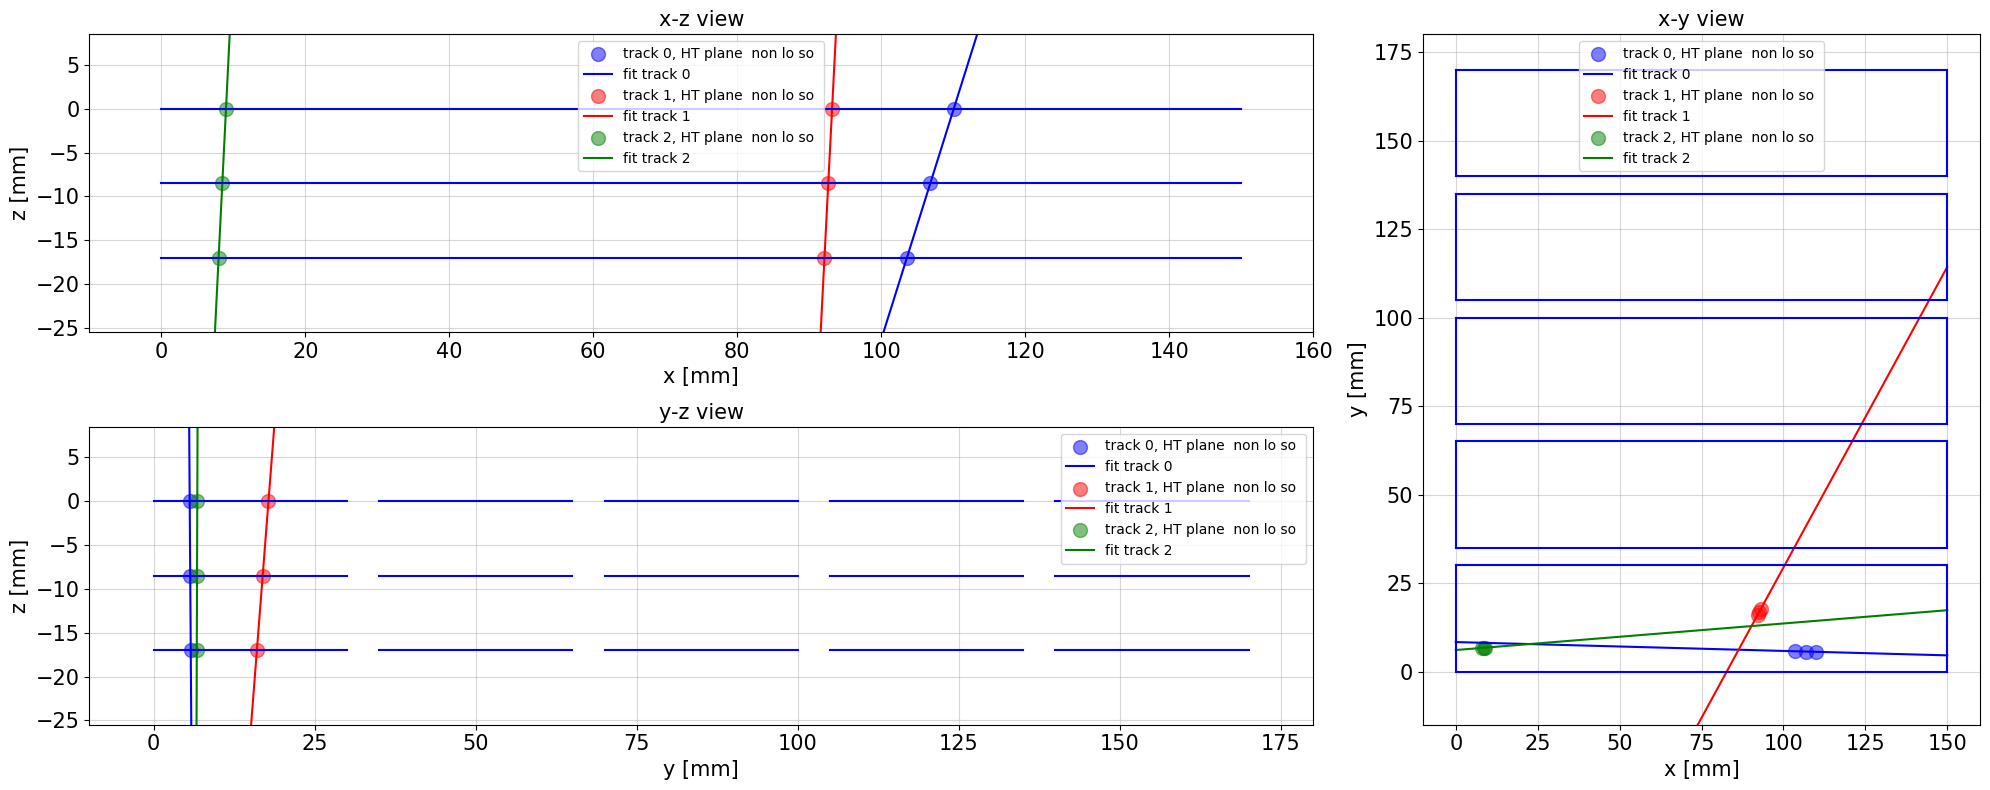

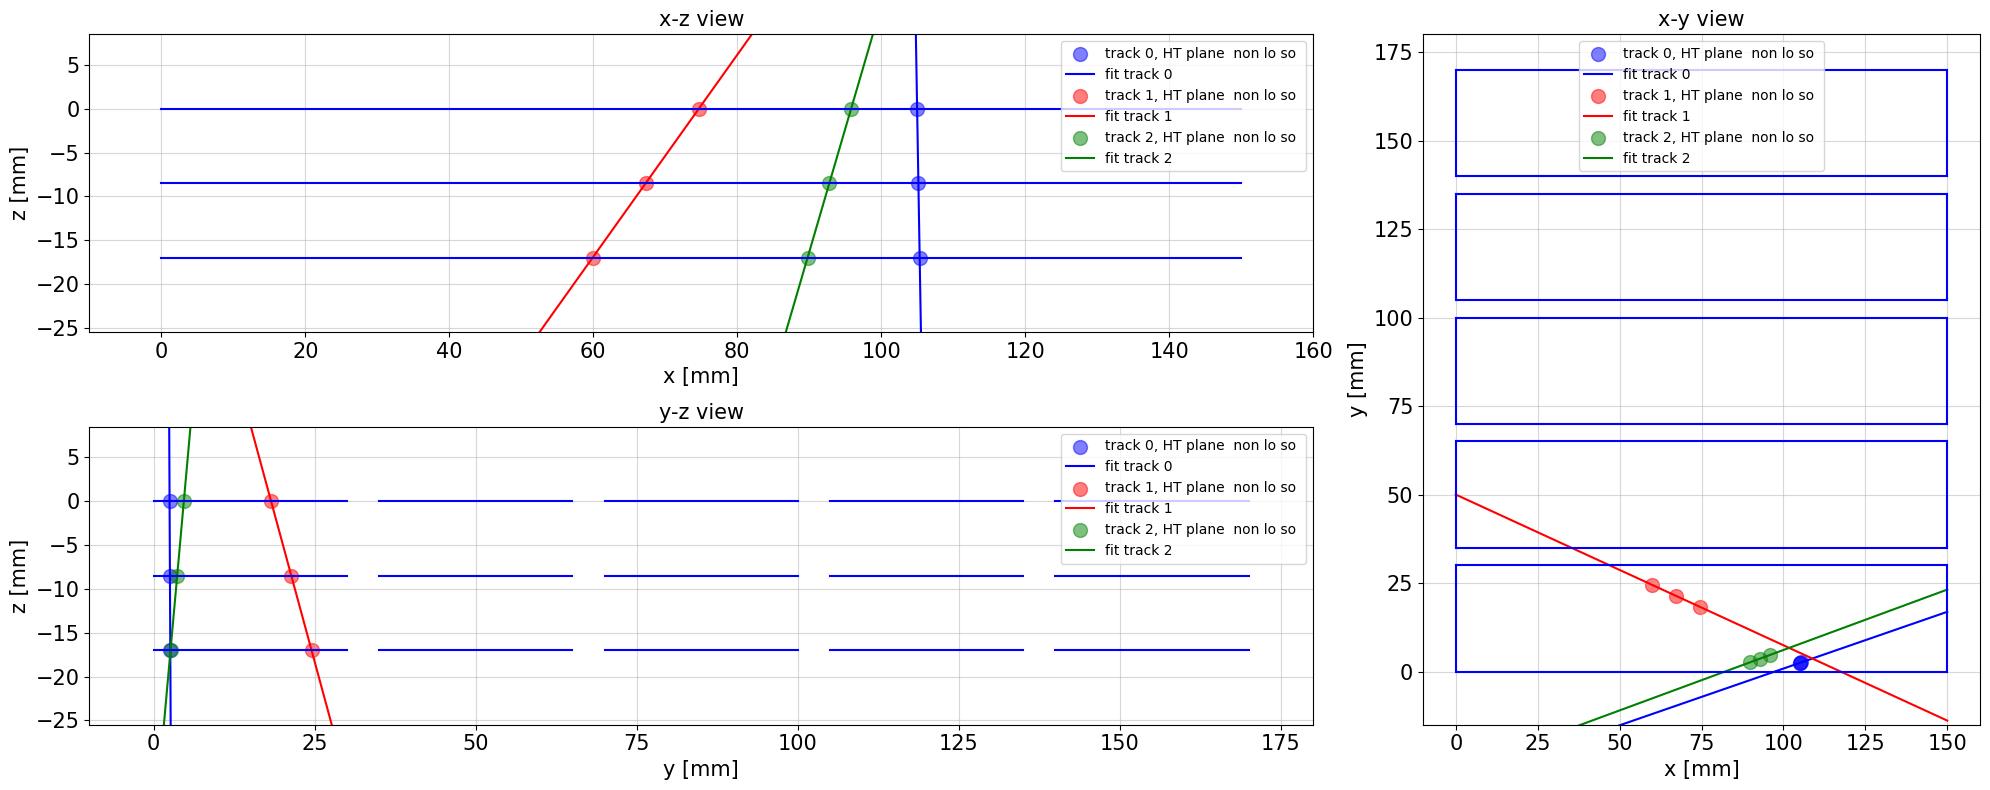

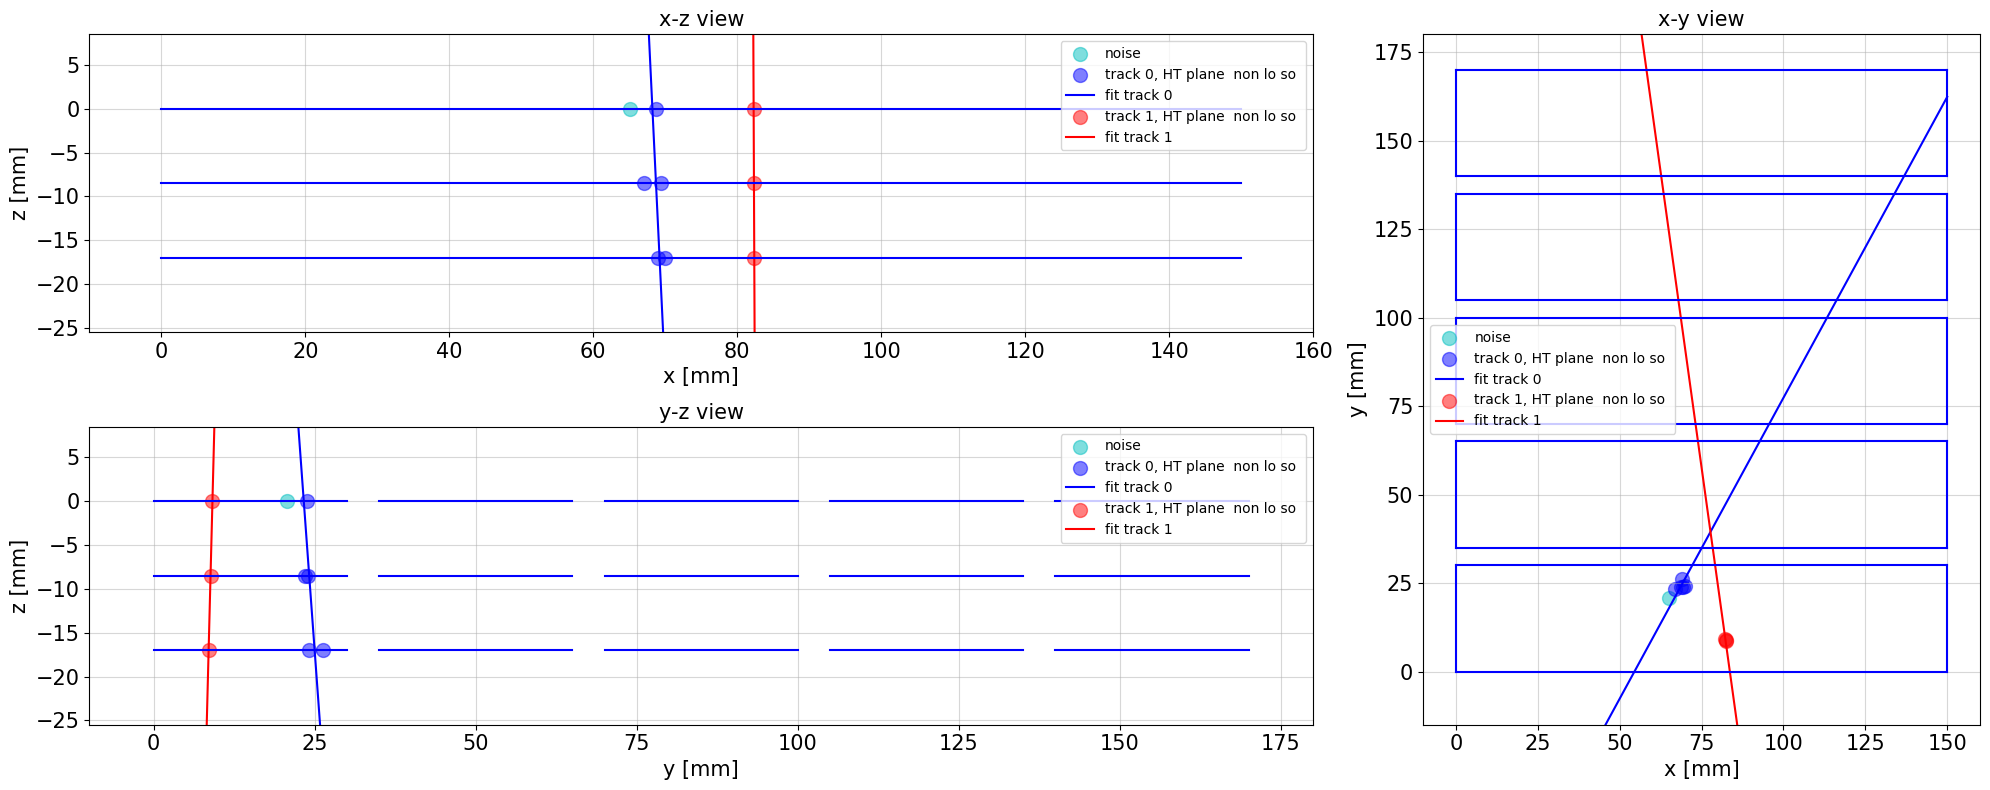

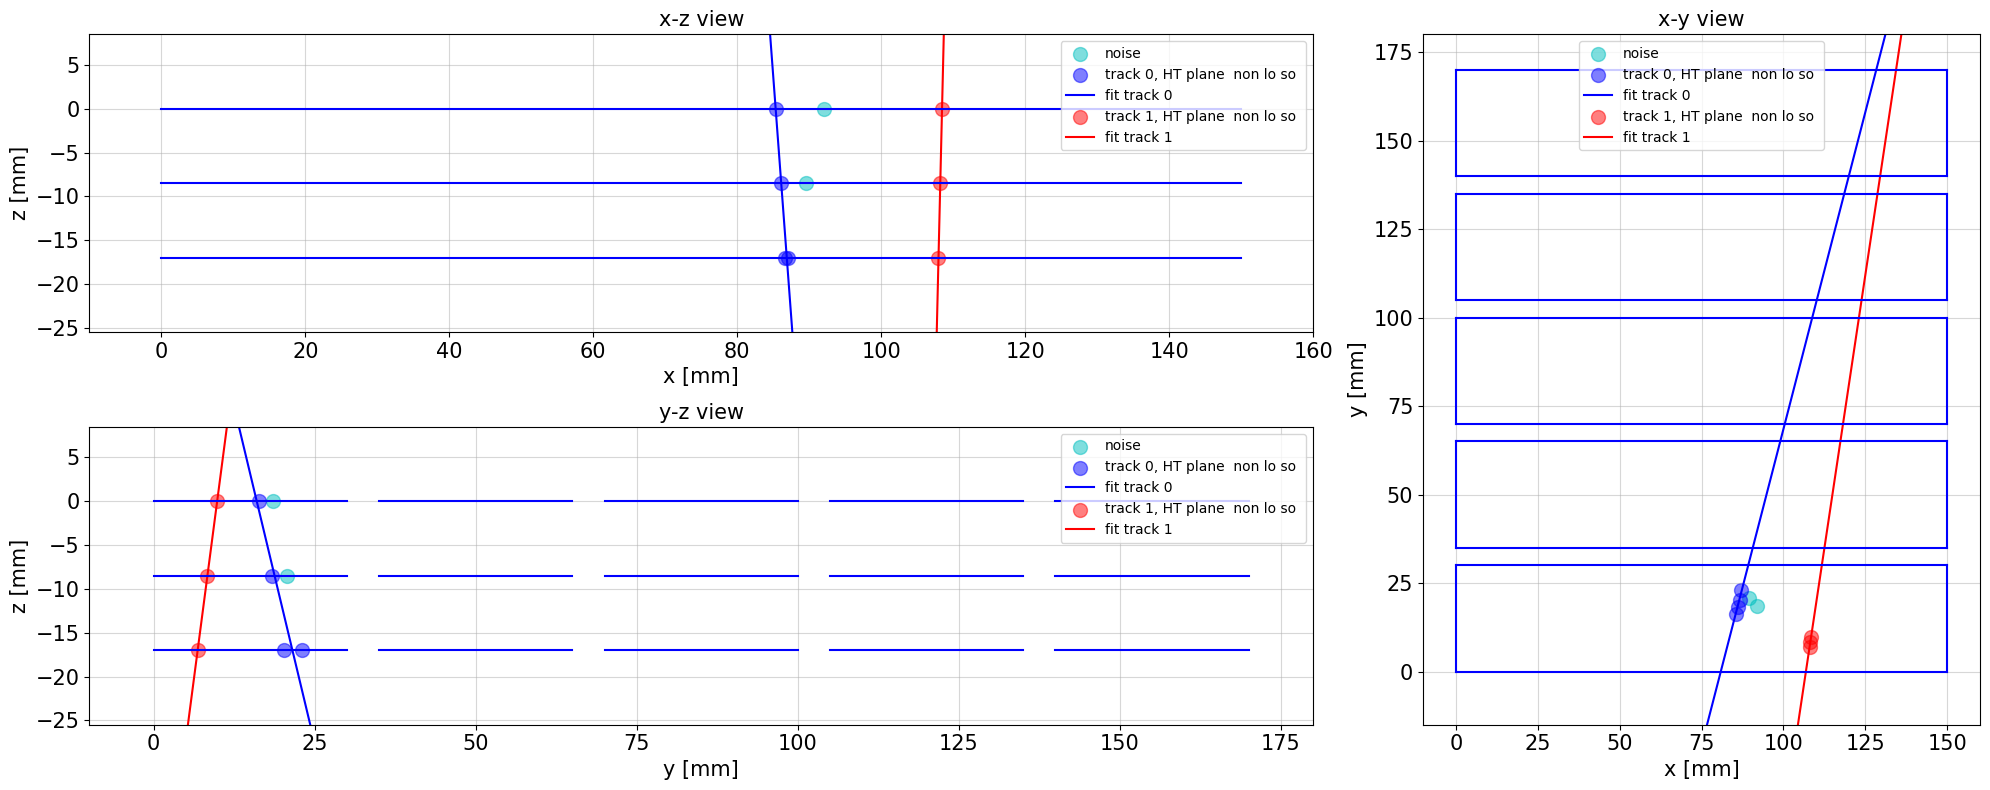

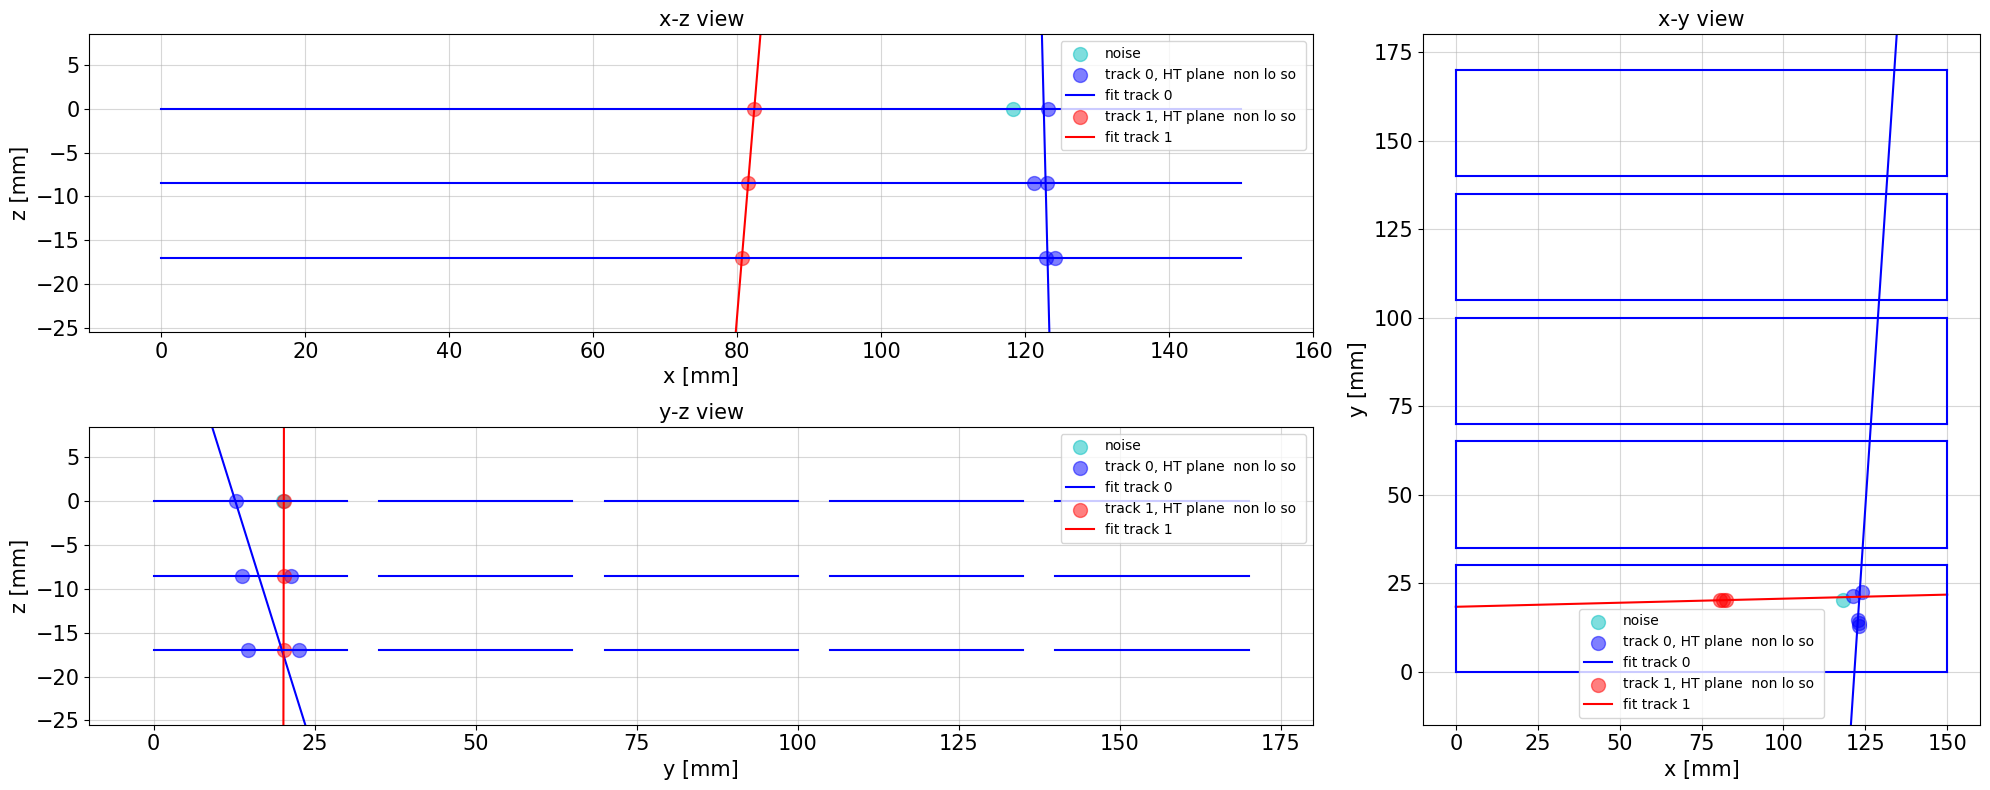

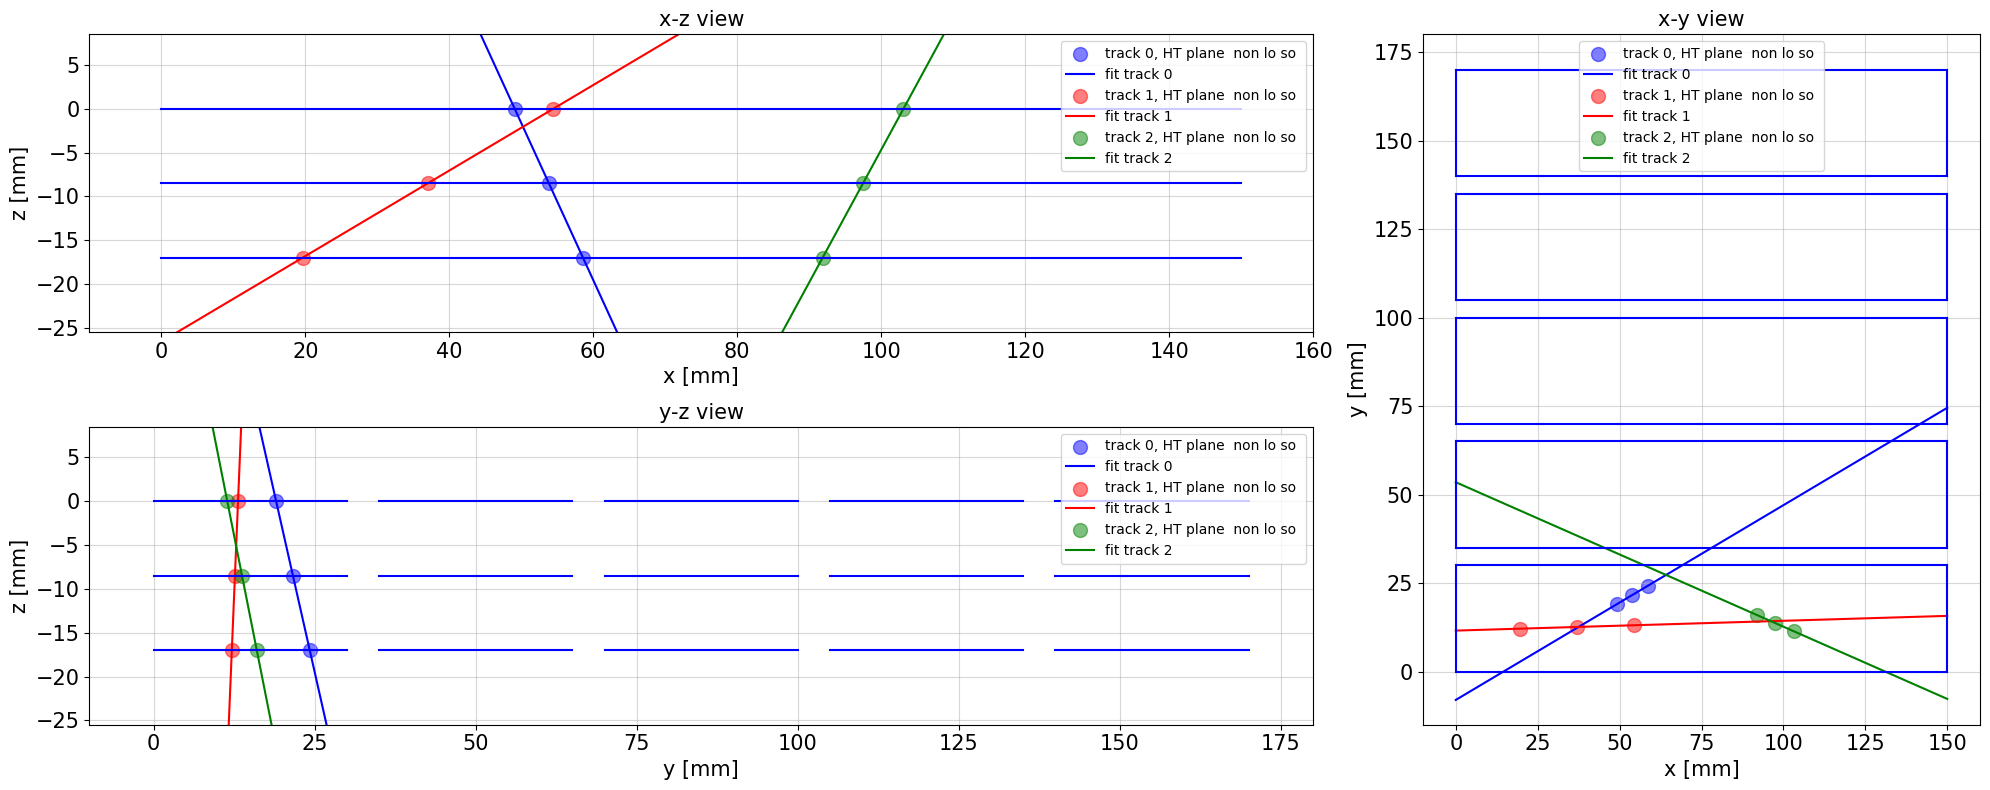

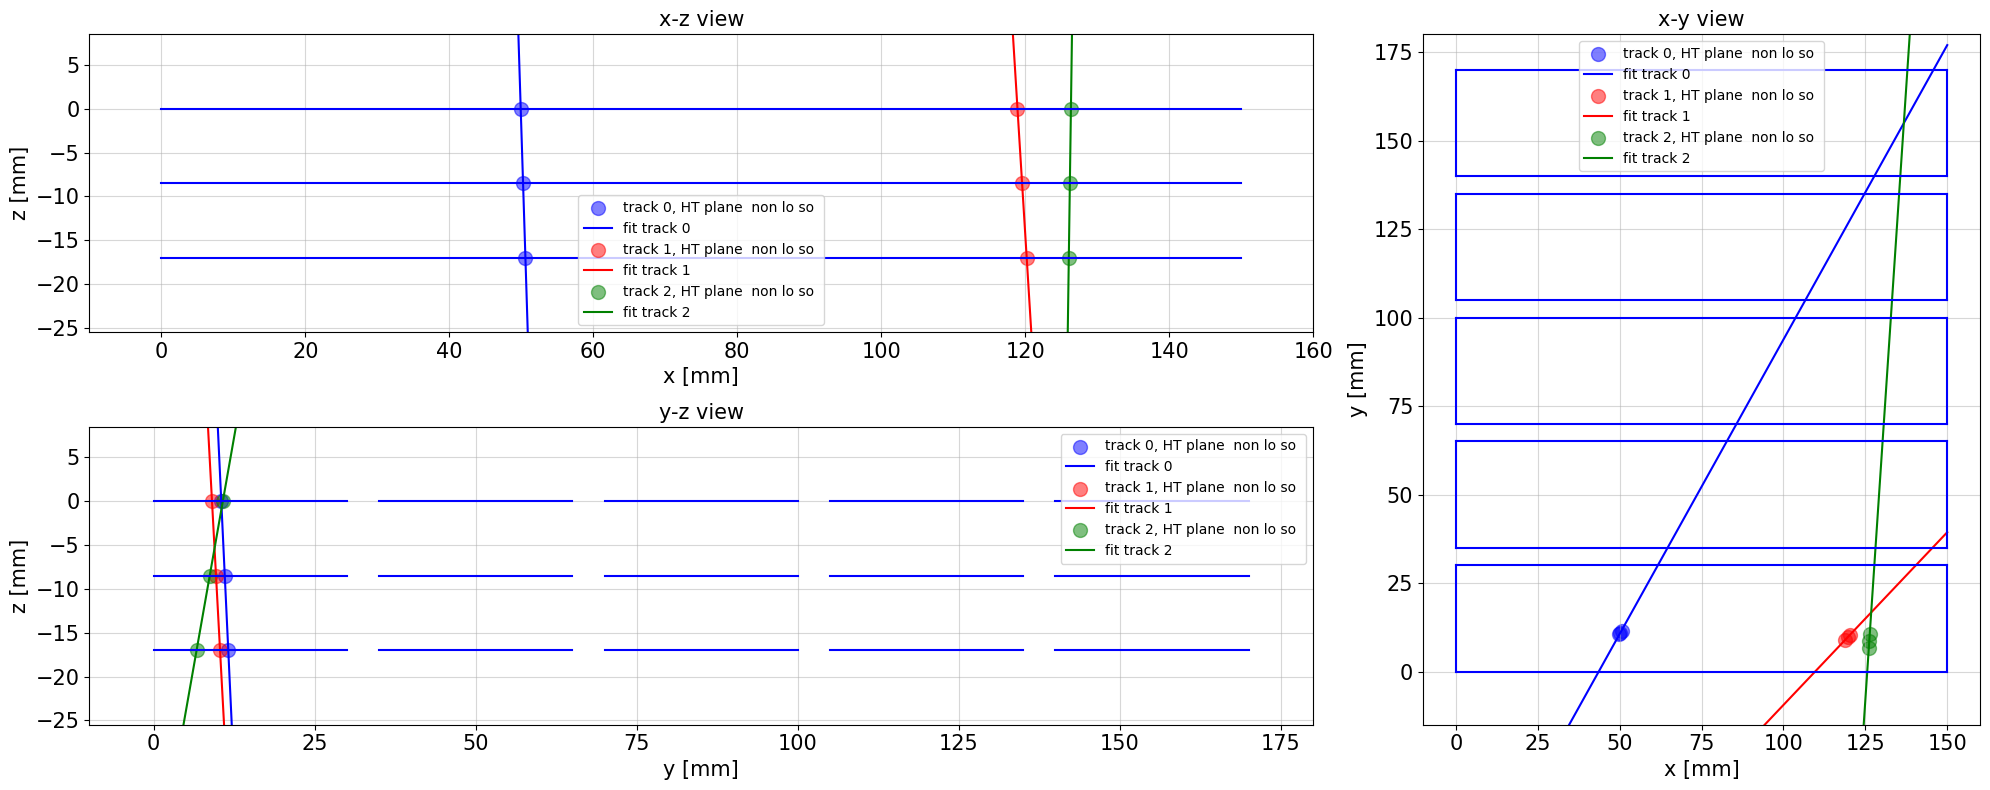

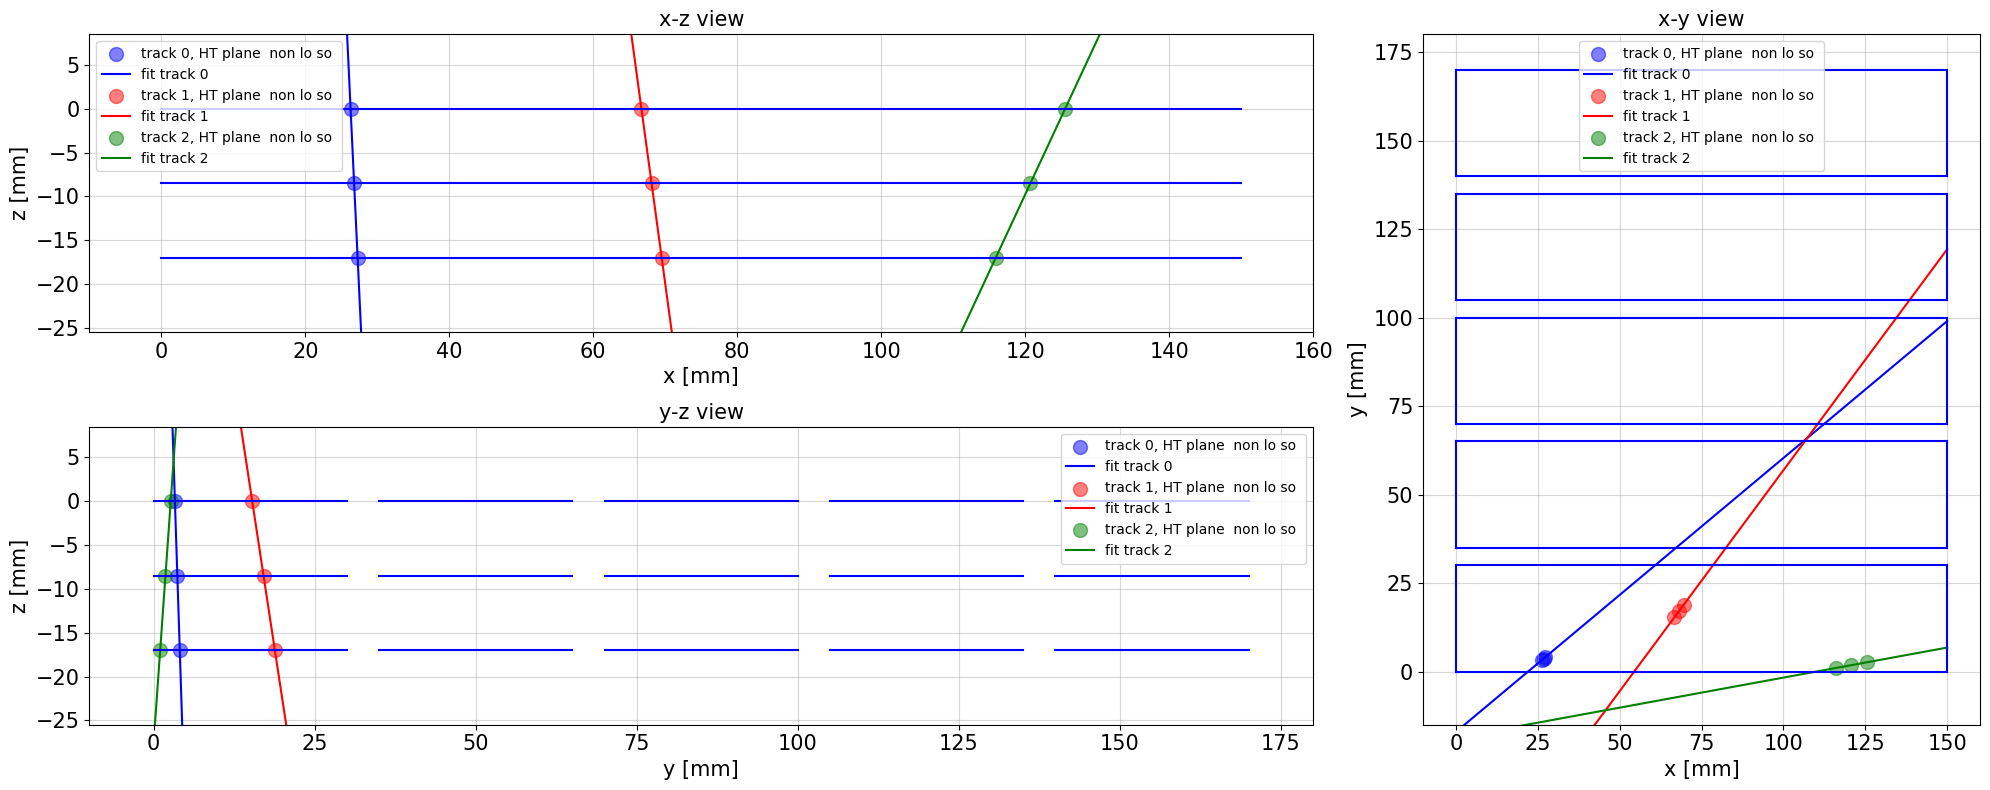

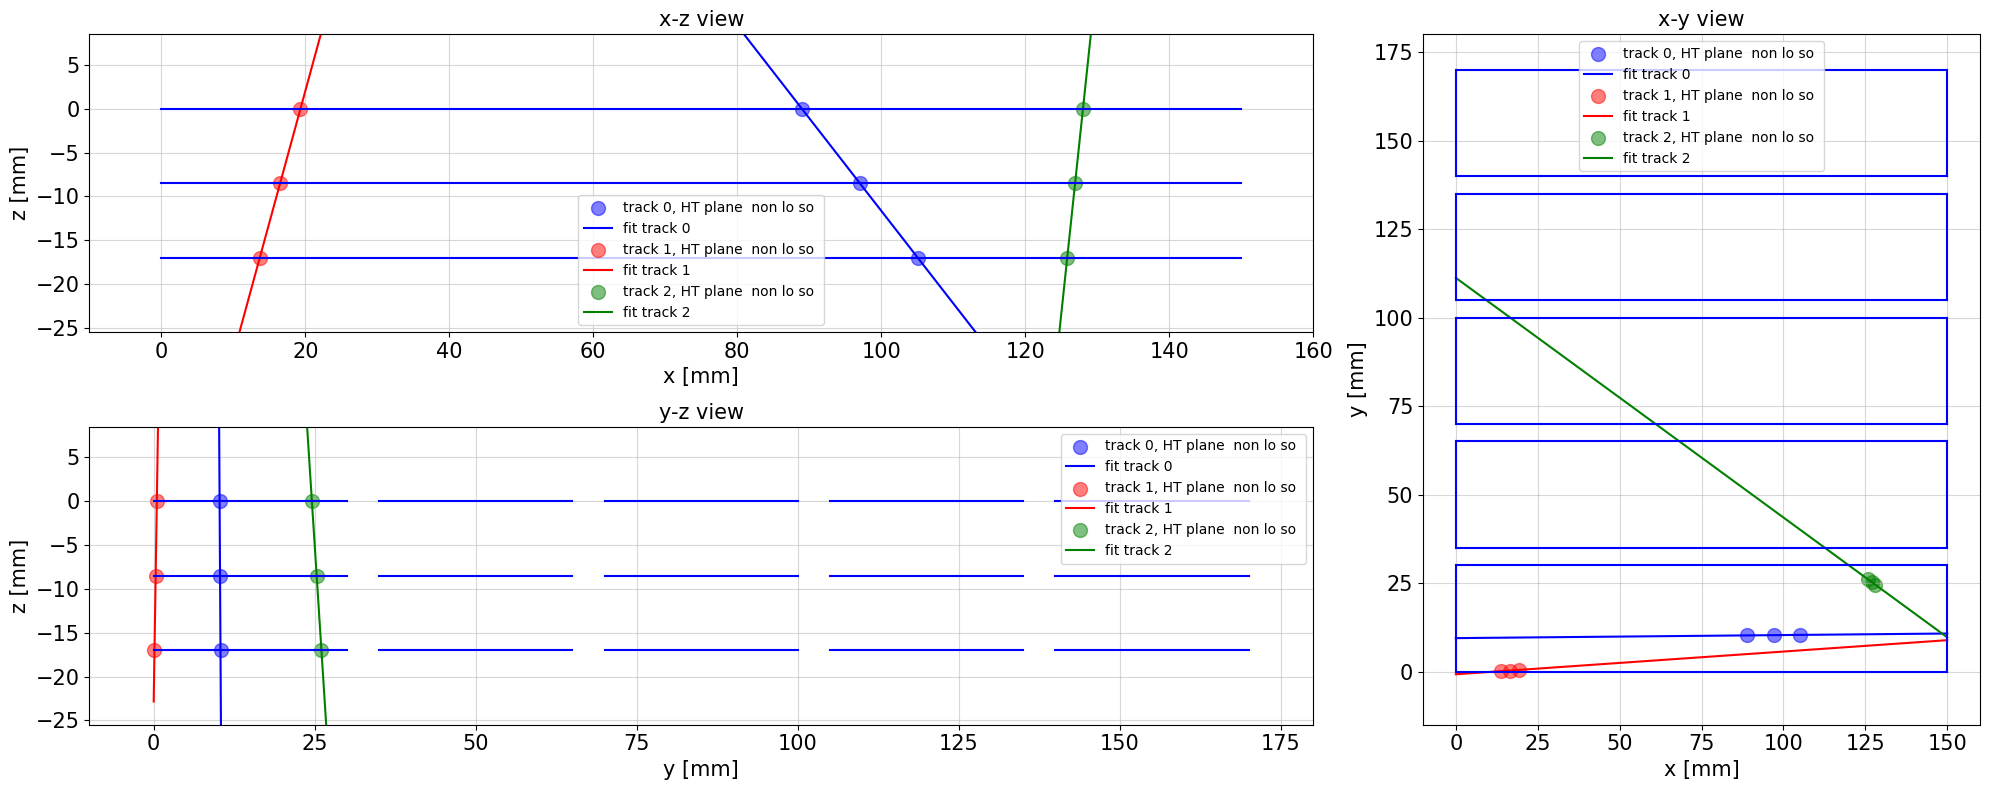

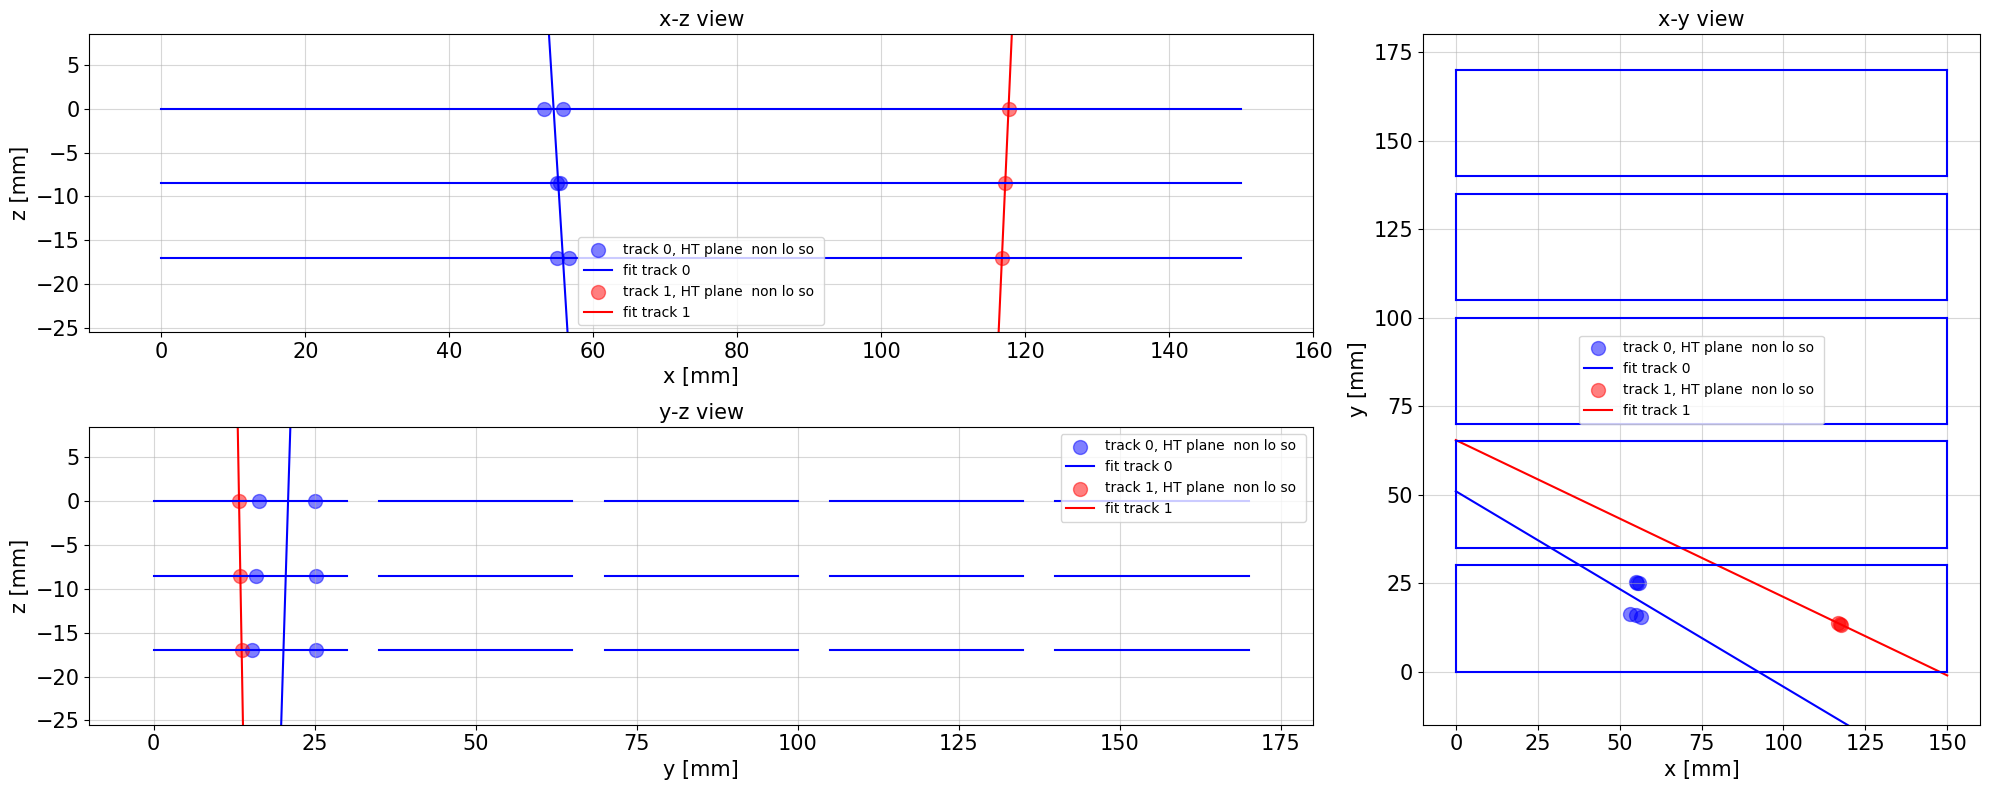

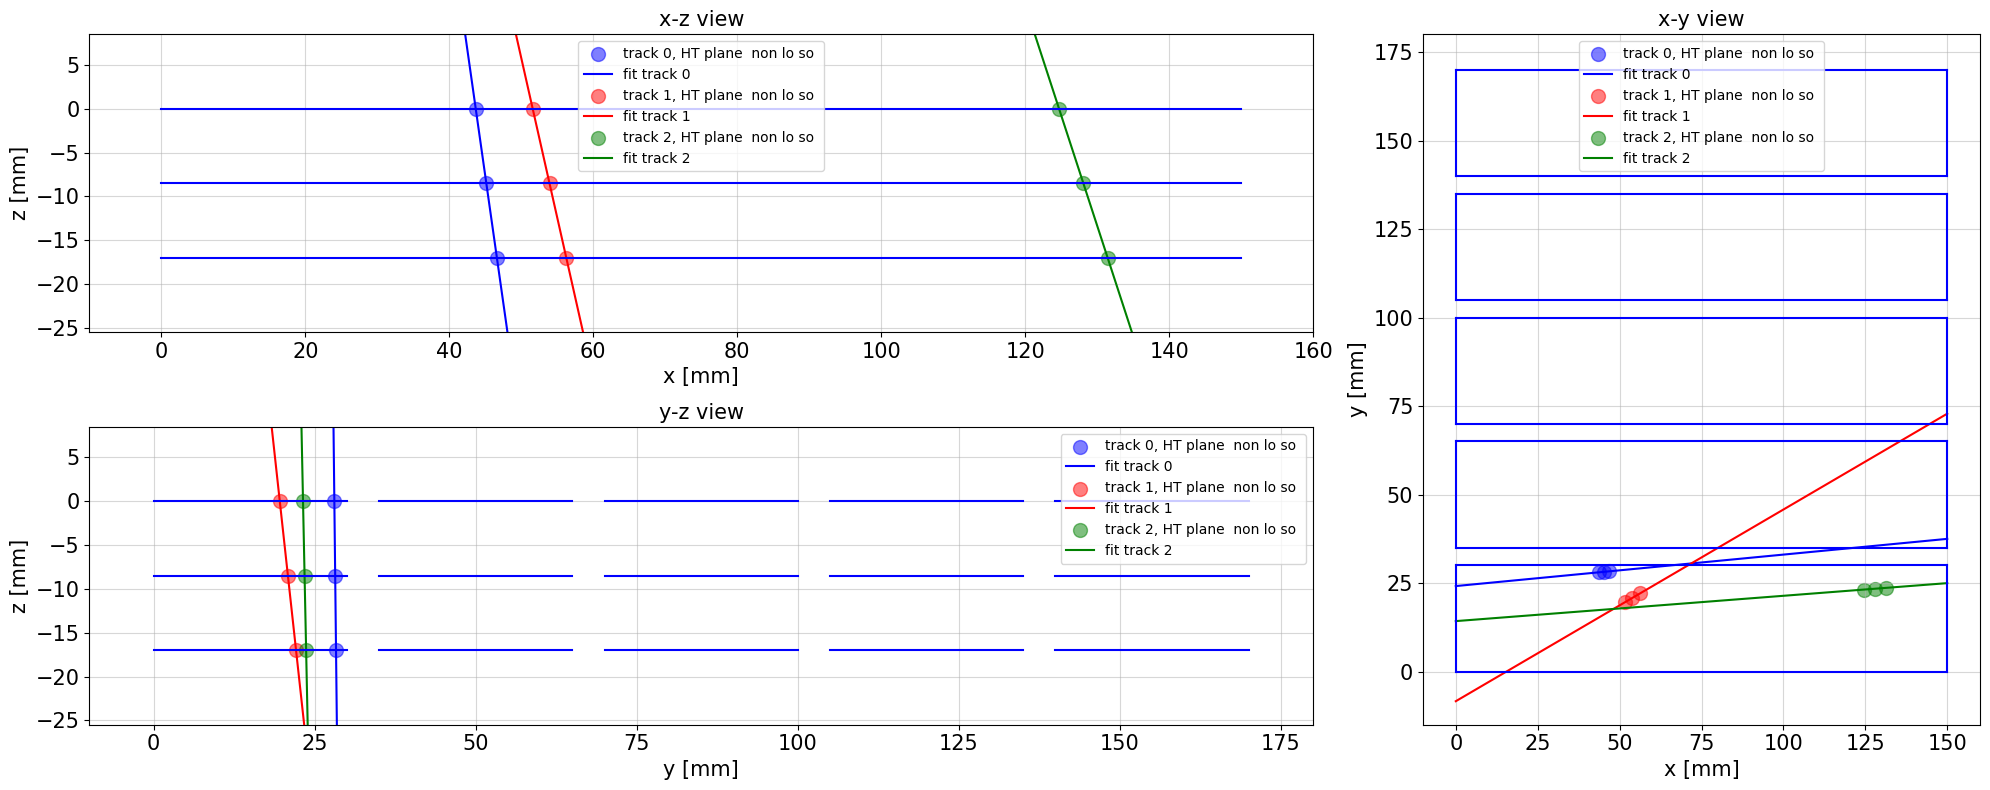

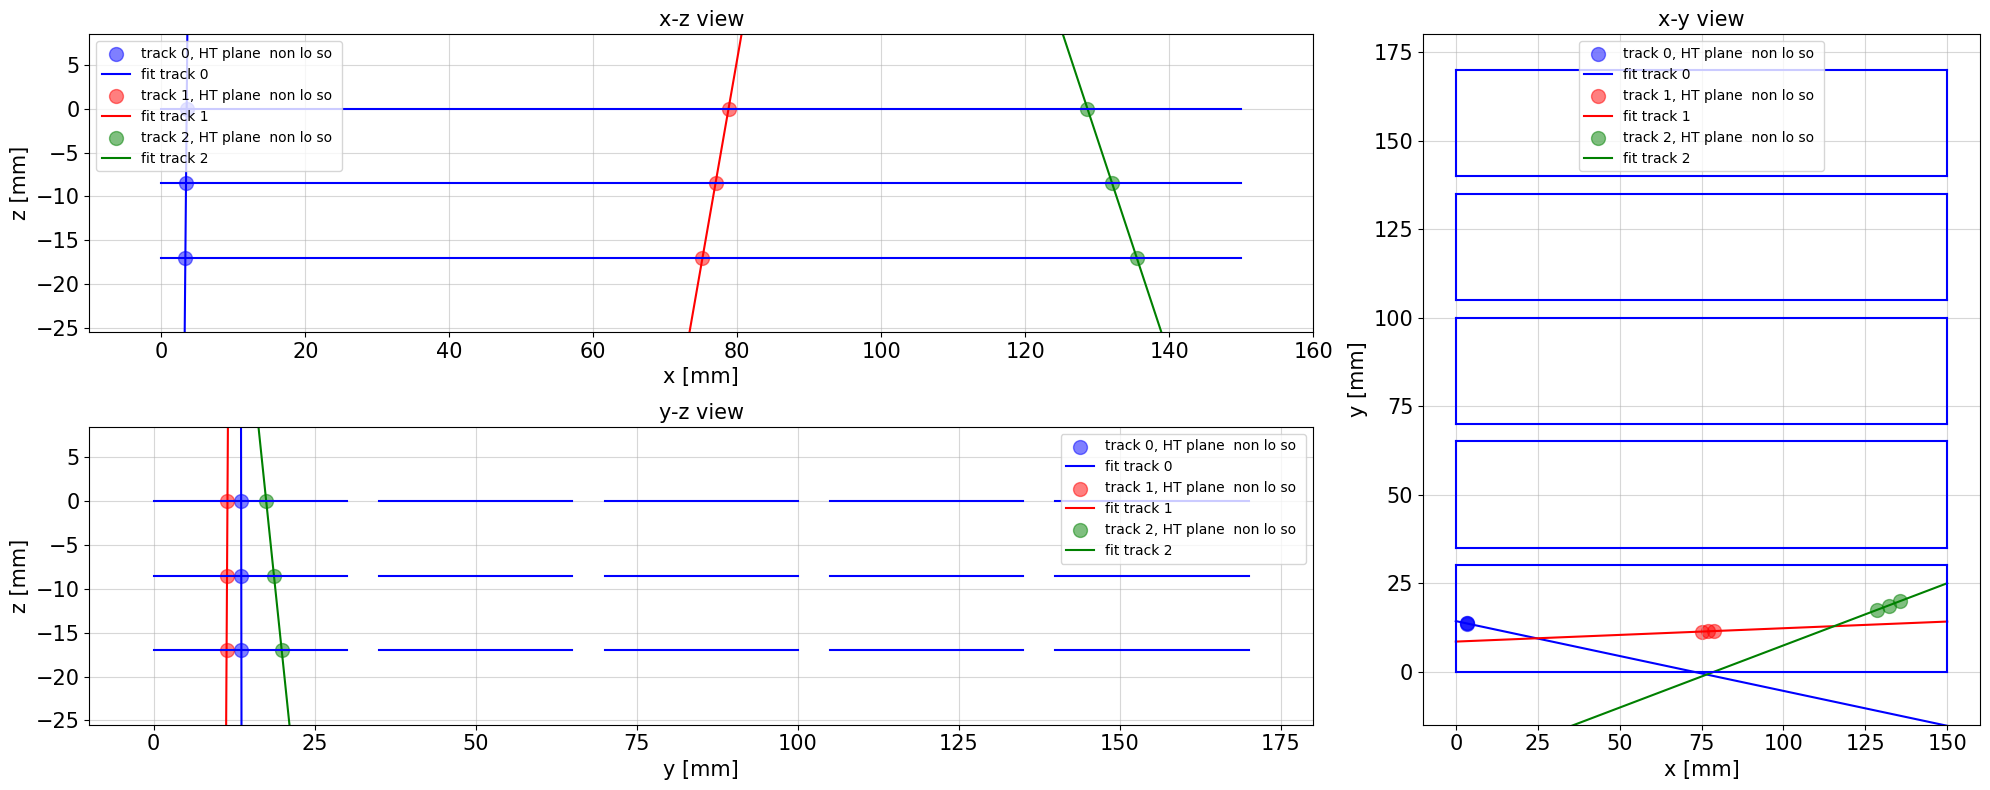

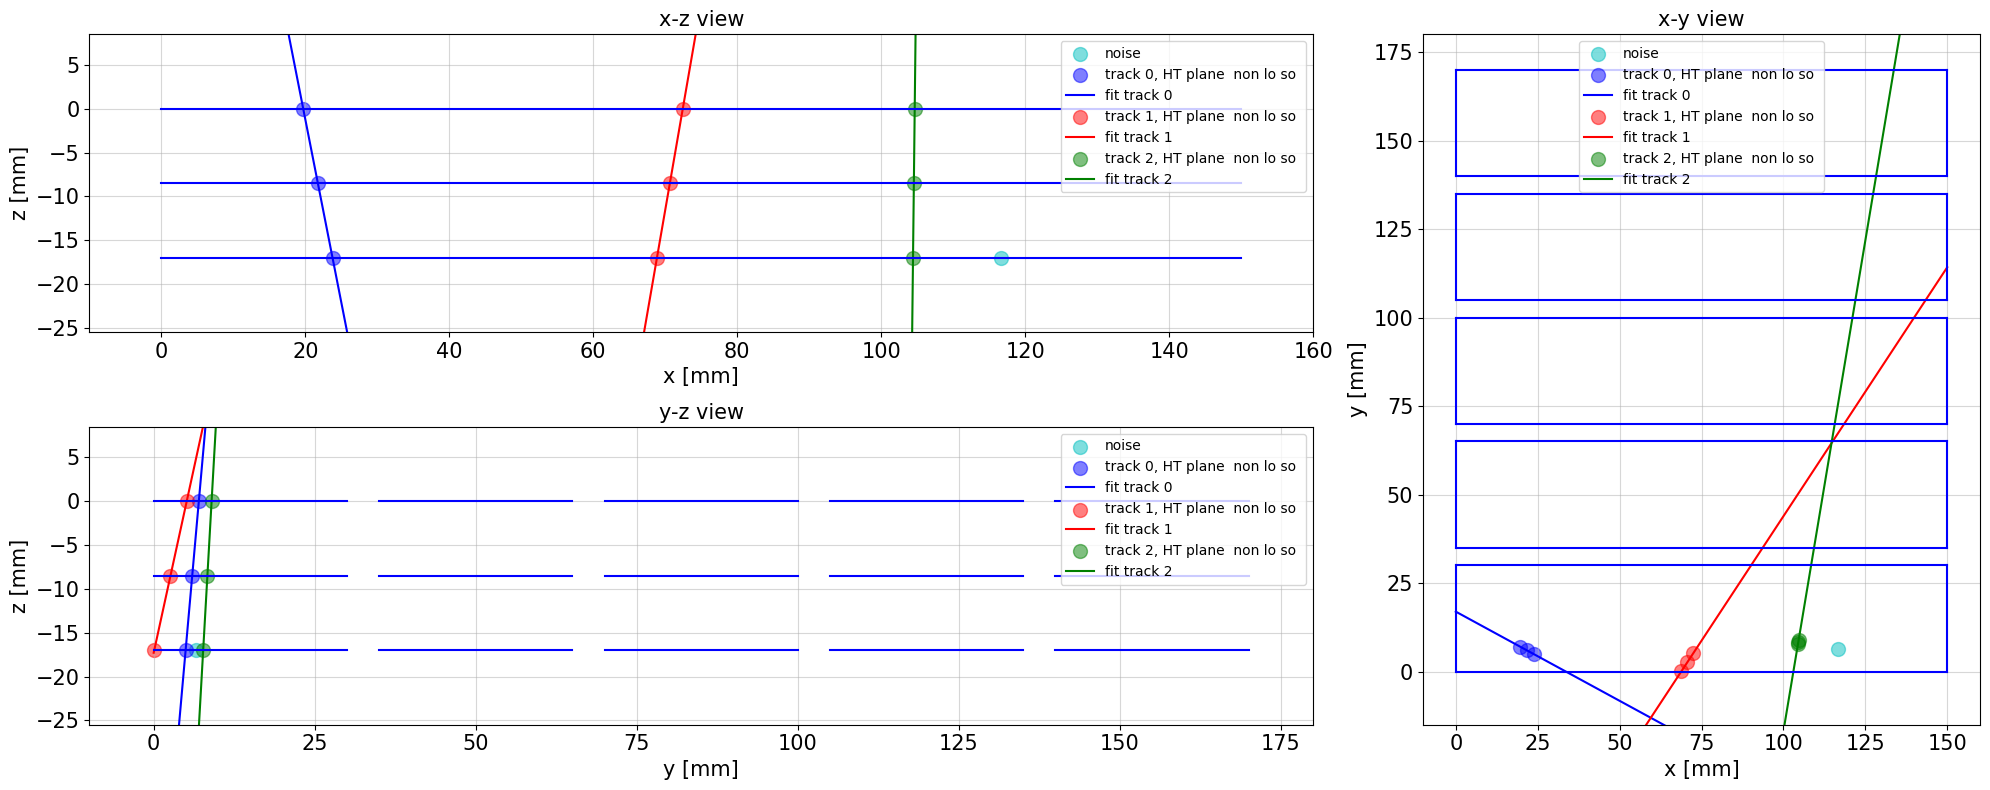

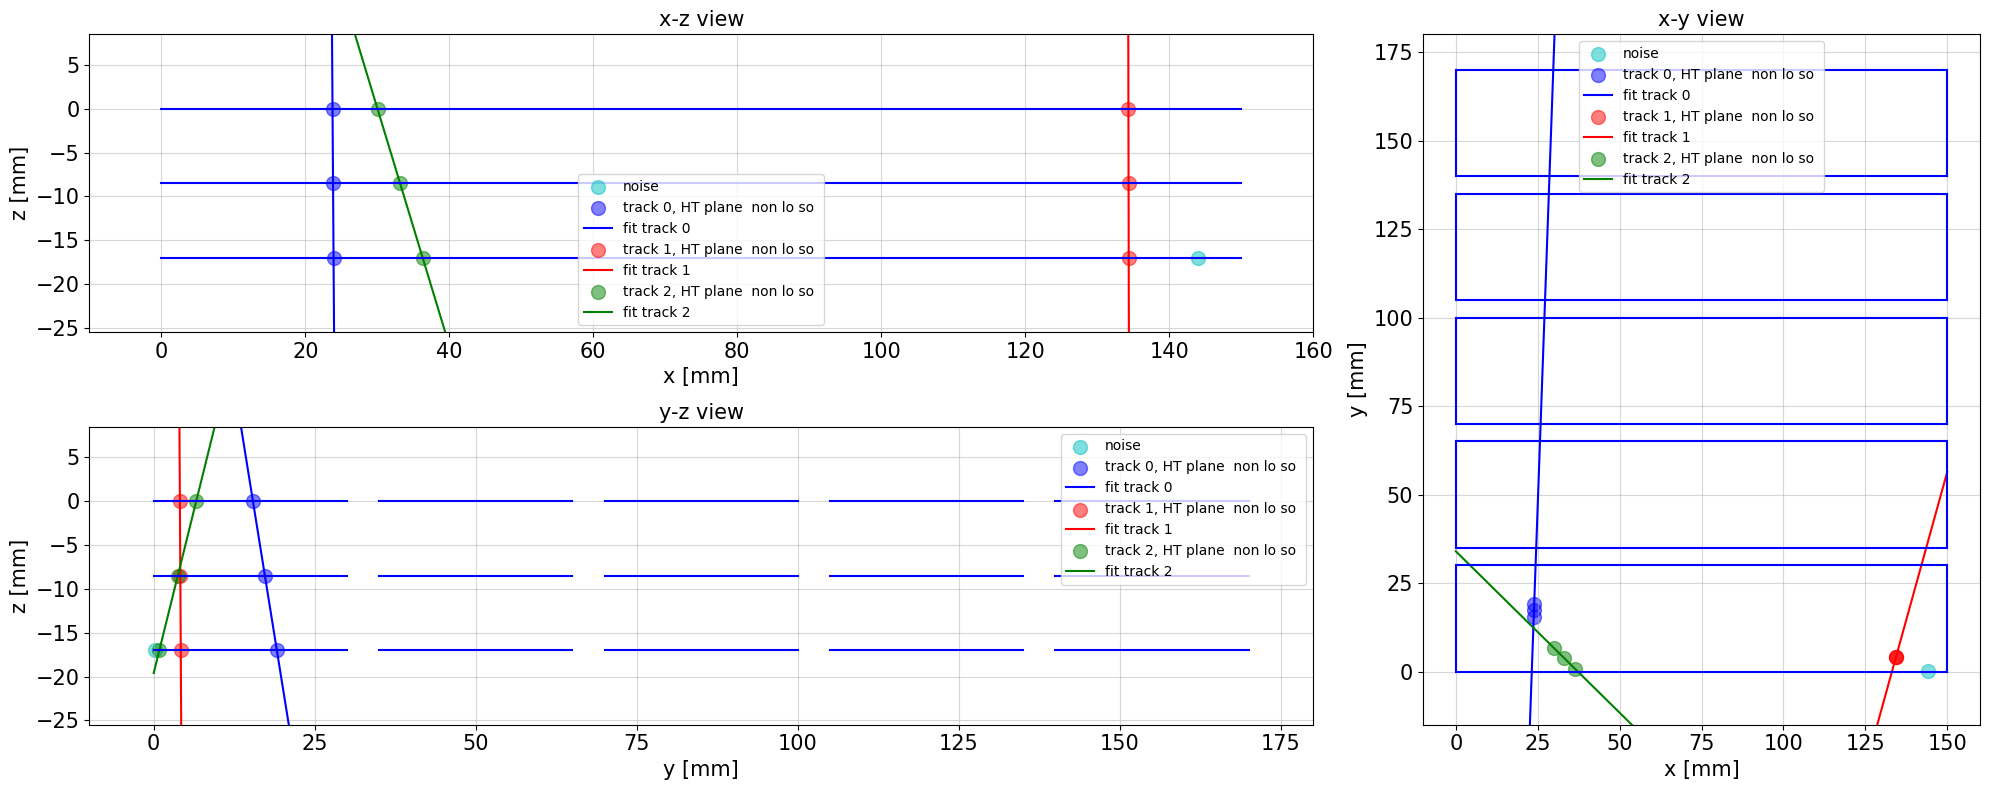

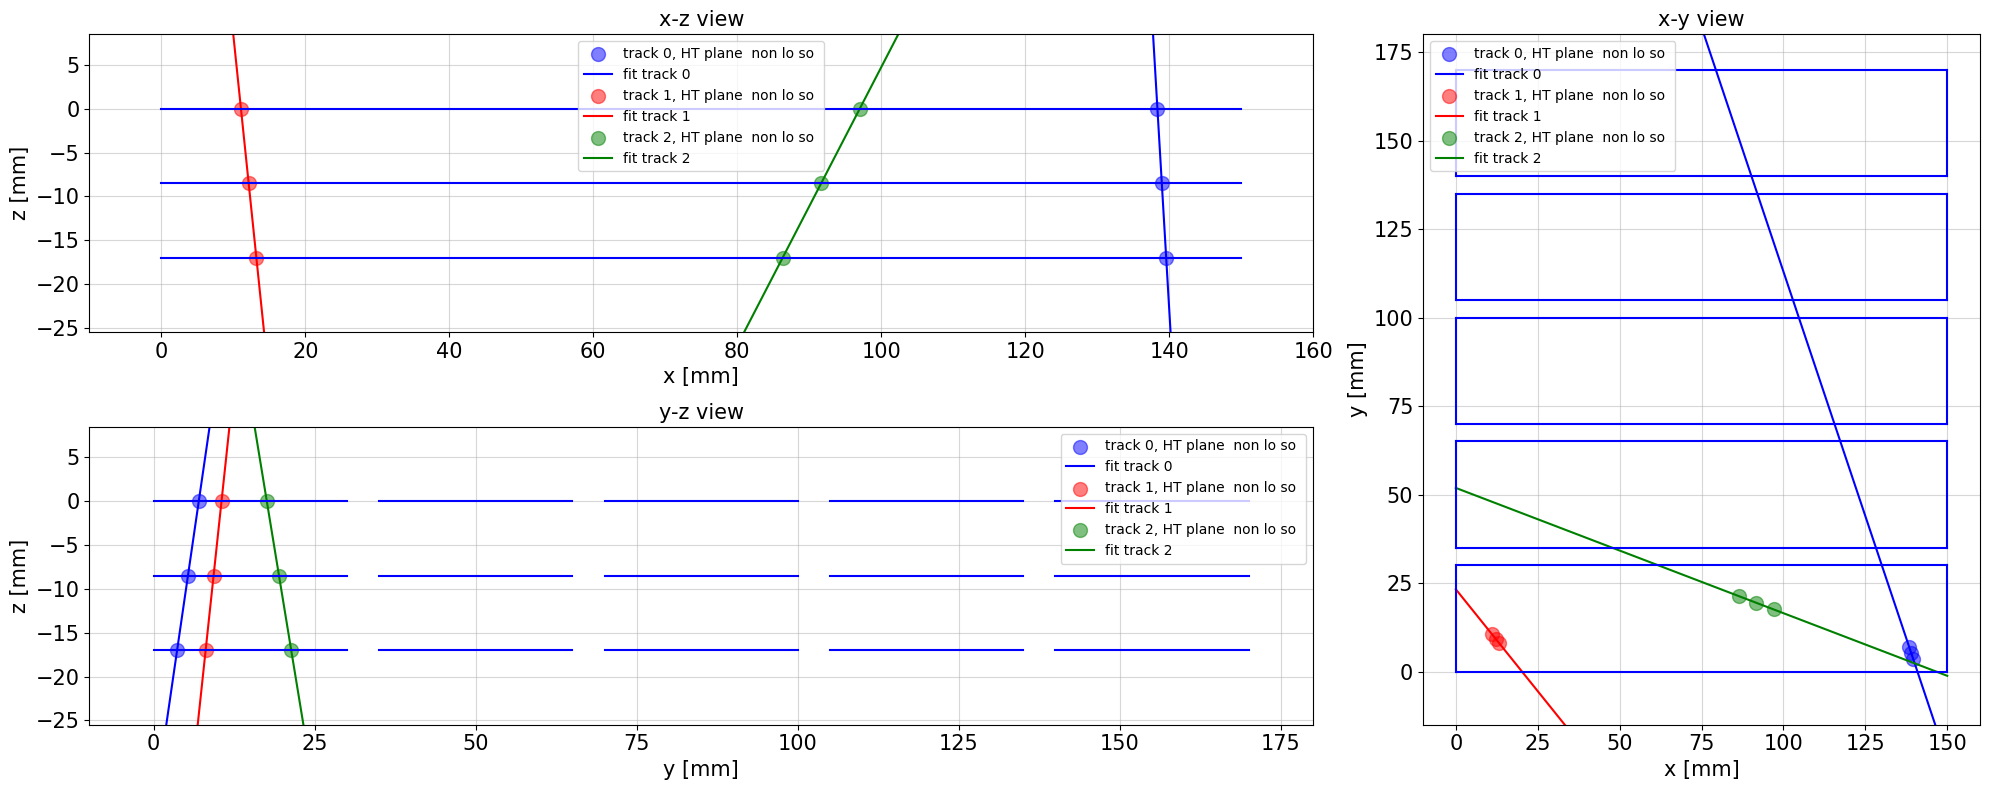

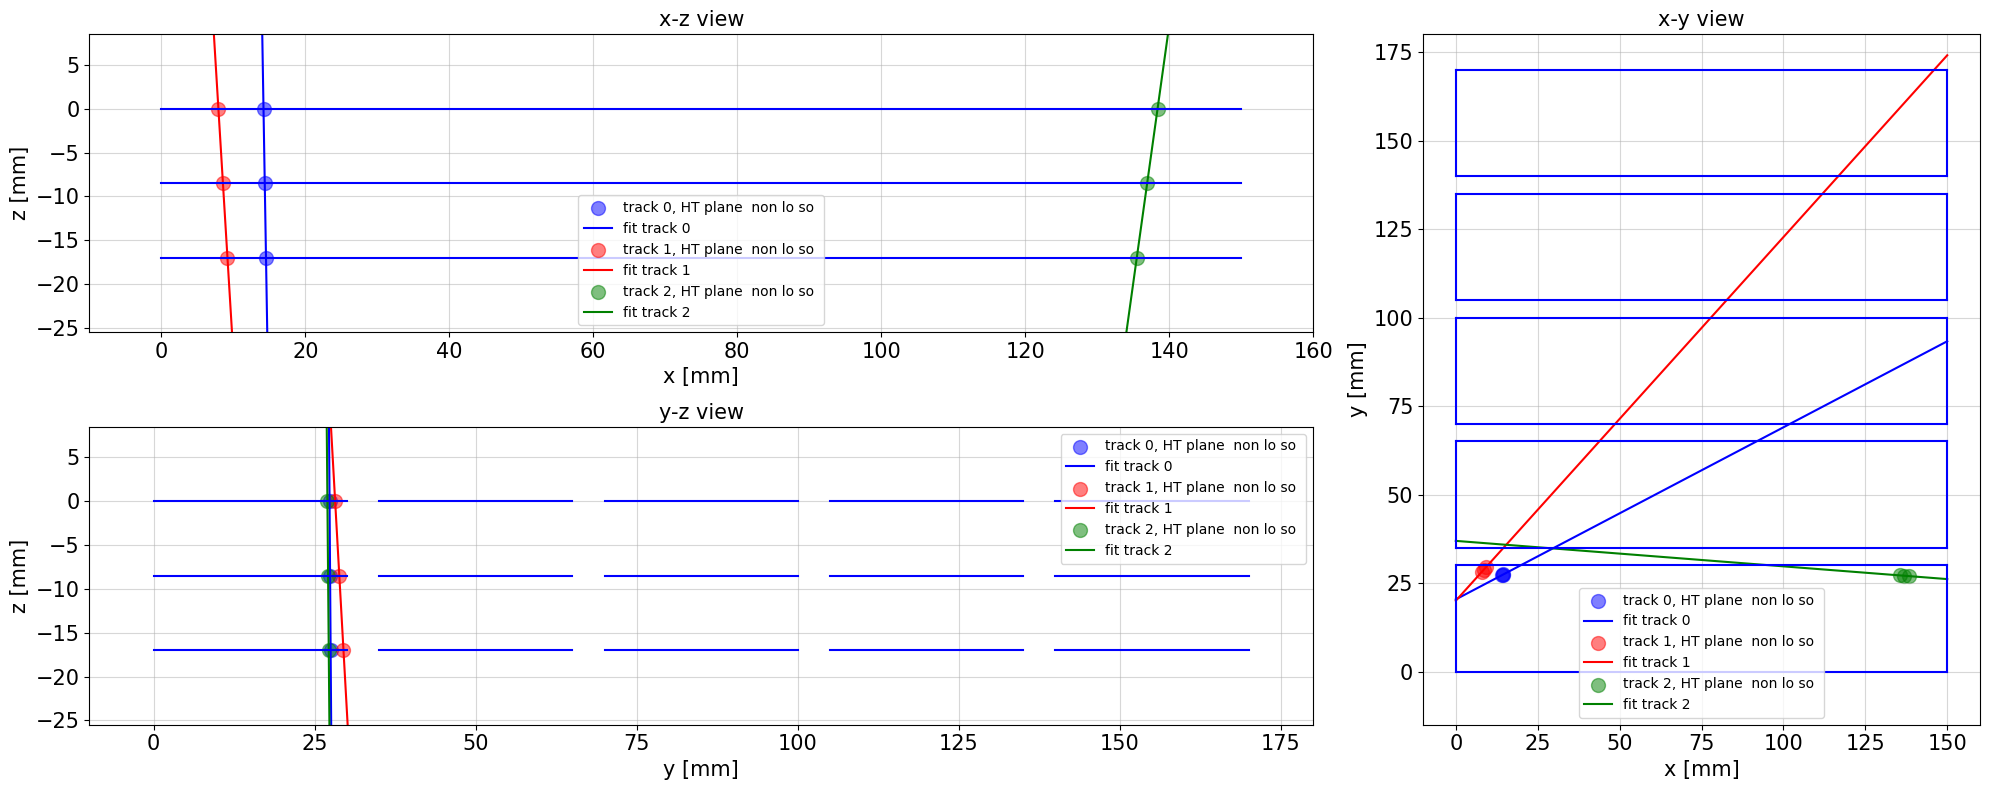

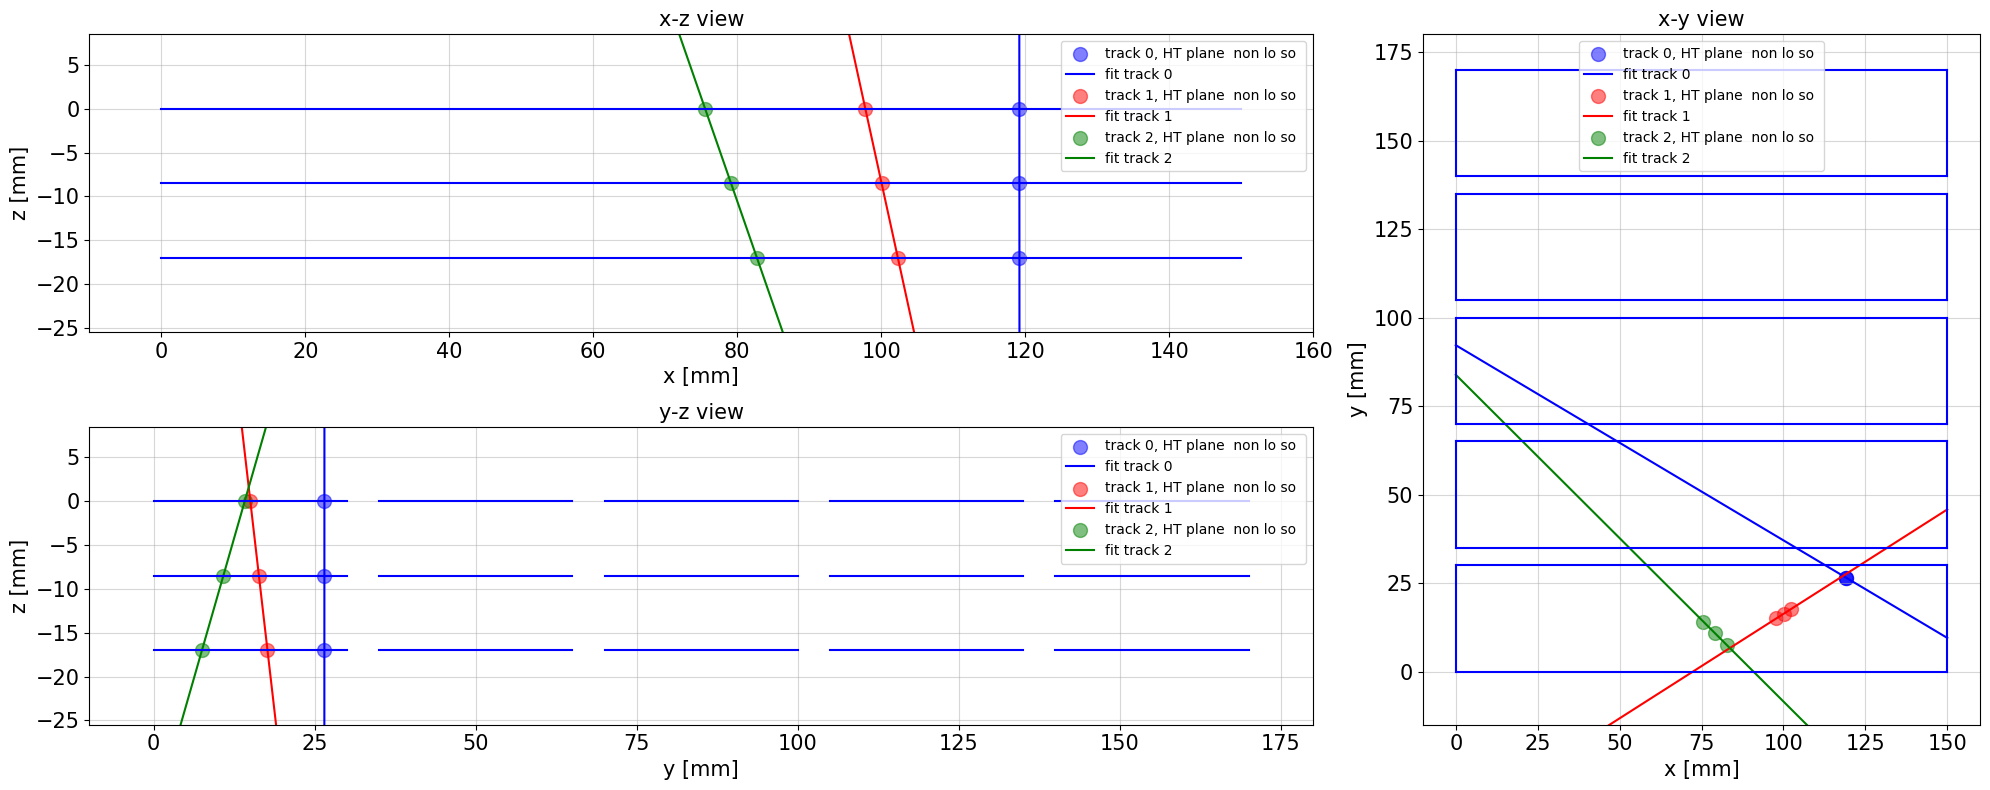

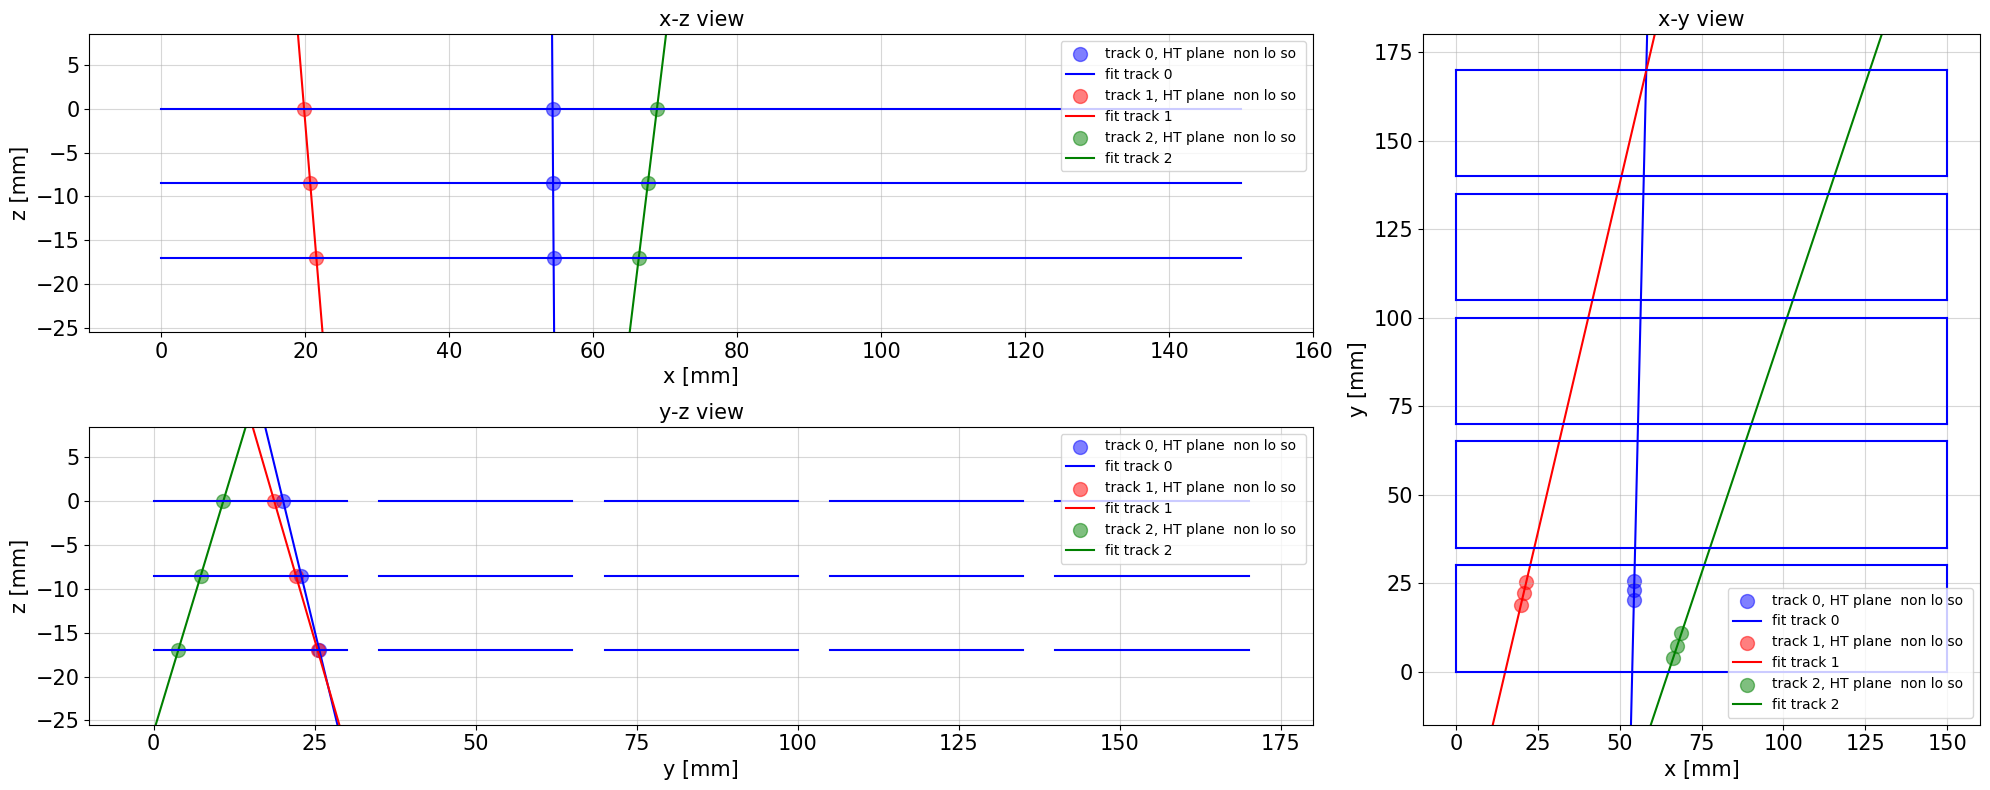

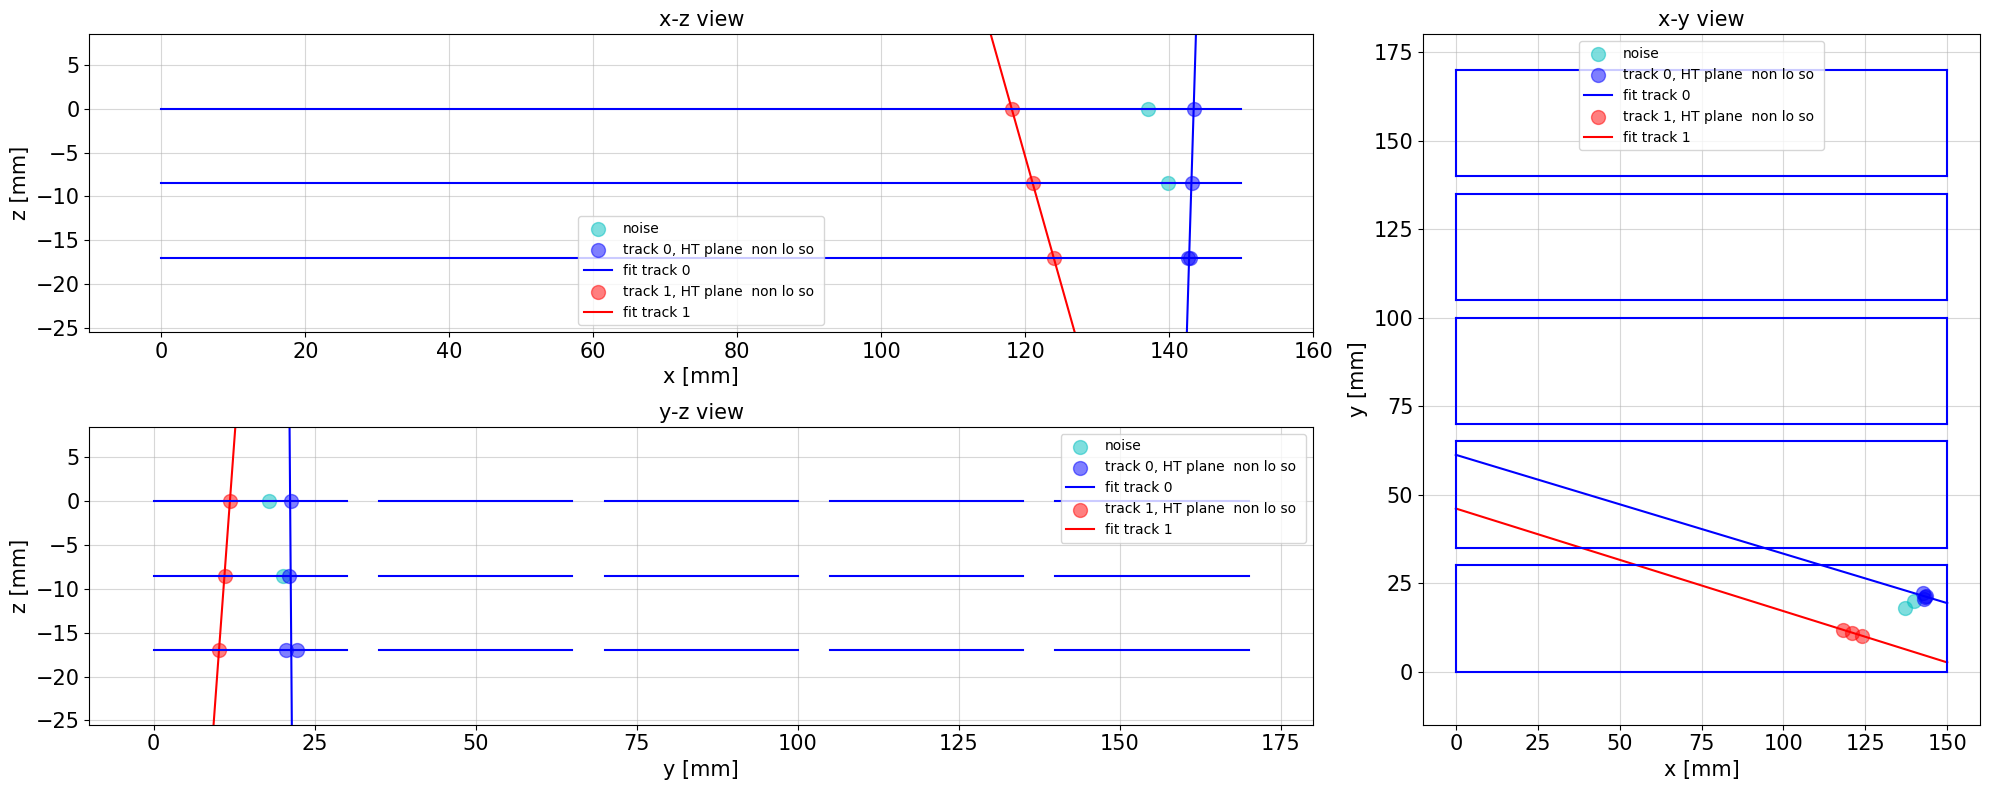

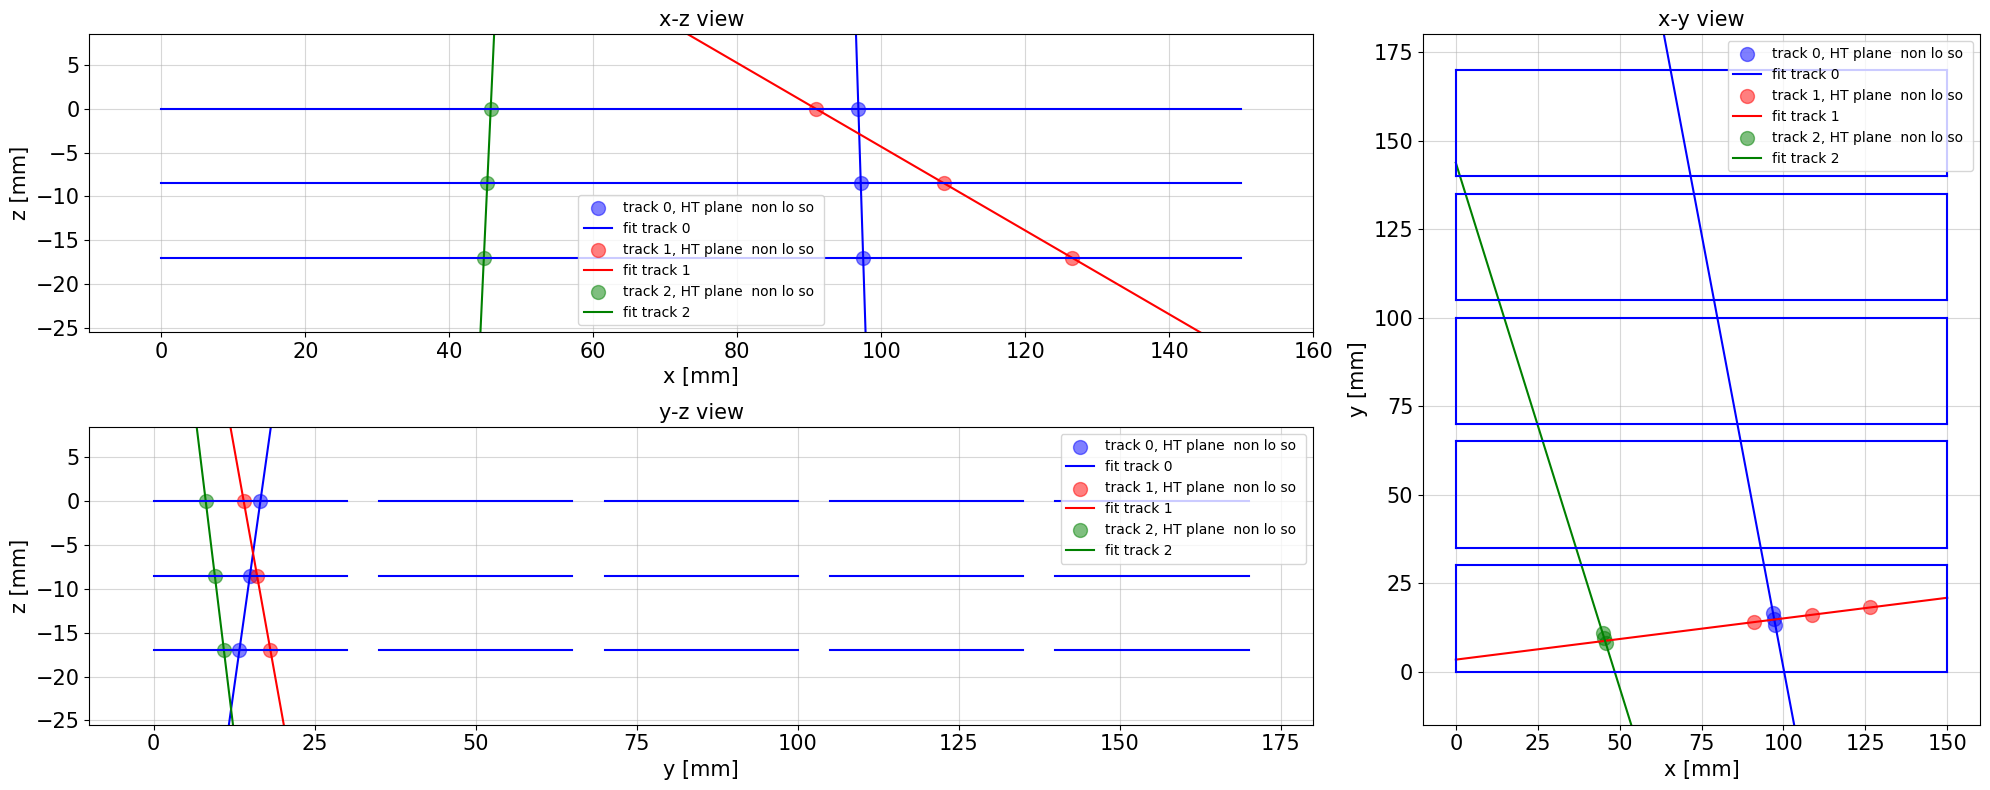

In [8]:
for id_ev in np.unique(df.event.values):
    print(id_ev)
    df = df.rename(columns={"trk_index": "trk_nr"})
    df_ev = df[df.event == id_ev]
    # now run the fit/display on it:
    tracks_df, vecs, pts = fit_oneevent_display(df_ev)
    ev = tracks_df[tracks_df.event==id_ev]
    display_single_fit(ev, vecs, pts, "event"+str(id_ev)+"_fit.png", " non lo so ")

In [ ]:
# load your generated tracks